# Проект по бинарной классификации рисков сердечного приступа

## Обзор и цели

Этот проект посвящён разработке модели бинарной классификации, предсказывающей высокий или низкий риск сердечного приступа по реальным медицинским данным. Цель — провести исследовательский анализ данных (EDA), построить точную и интерпретируемую модель, а затем развернуть её как приложение FastAPI для получения предсказаний на новых данных.

Датасет включает ключевые группы признаков:
- Антропометрия: возраст, индекс массы тела (ИМТ).
- Образ жизни: курение, употребление алкоголя, физическая активность, диета.
- Клинические измерения: артериальное давление, частота сердечных сокращений.
- Лабораторные показатели: холестерин, триглицериды, уровень глюкозы.
- Сердечные биомаркеры: тропонин, CK-MB.
- Медицинский анамнез: диабет, семейная история сердечных заболеваний, прошлые сердечные события, приём лекарств и др.

Проект состоит из двух частей:
1. Анализ данных и построение модели классификации.
2. Развёртывание сервиса на FastAPI для онлайновых предсказаний риска.


## Ключевые задачи

1. **EDA (разведочный анализ):** изучить распределения признаков, выявить аномалии, пропуски и возможные утечки.
2. **Предобработка данных:** обработать пропуски, закодировать категориальные признаки, удалить/трансформировать вводящие в заблуждение признаки.
3. **Инженерия признаков:** использовать доменные знания (например, расчёт риск-скоров, агрегирование факторов риска) для улучшения качества модели.
4. **Моделирование:** обучить и сравнить несколько моделей классификации; акцент на ансамблях (**Random Forest**, **XGBoost**, **CatBoost**), избегая чрезмерно простых подходов.
5. **Метрики и валидация:** выбрать метрики с учётом дисбаланса классов и клинической значимости (например, ROC-AUC, PR-AUC, recall, F2), обосновать выбор.
6. **Интерпретируемость:** применить **SHAP** для выявления ключевых факторов и проверки согласованности поведения модели с медицинскими знаниями.
7. **Продакшн (FastAPI):** разработать сервис, принимающий вход (CSV/JSON) и возвращающий уровни риска в формате JSON.
8. **Документация и код:** подготовить воспроизводимый, структурированный код (ООП-подход), ноутбук с анализом, артефакты предсказаний и инструкцию по использованию.


In [32]:
# Библиотеки
from __future__ import annotations
import re
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
from pathlib import Path
from typing import Tuple, Optional, List, Dict, Any
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, f1_score, fbeta_score, precision_score, recall_score,
    brier_score_loss
)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier, Pool

# SHAP (опционально; будет бэкап на permutation importance)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False




### Предварительный обзор датасетов

In [33]:
# Функции для предварительного обзора

def quick_overview(df, target=None):
    """Общий обзор: размер, типы, пропуски, дубликаты, баланс таргета."""
    print("Внешний вид:", df.head().T)
    print("Размер:", df.shape)
    print("\nТипы данных:\n", df.dtypes)
    print("\nПропуски (шт):\n", df.isnull().sum())
    dup = df.duplicated().sum()
    print(f"\nДубликатов: {dup} ({dup/len(df)*100:.2f}%)")
    if target and target in df.columns:
        print("\nБаланс таргета:")
        print(df[target].value_counts(normalize=True))


def quick_details(df, target=None, max_unique=10):
    """Детали: статистика чисел, min/max, категориальные частоты, уникальные значения, корреляции."""
    print("\n--- Статистика числовых признаков ---")
    print(df.describe())
    print("\n--- Min/Max по числовым ---")
    desc = df.describe()
    print(desc.loc[['min', 'max']] if 'min' in desc.index else desc[['min', 'max']])
    print("\n--- Частоты категориальных ---")
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].nunique() <= max_unique:
            print(f"\nЧастоты в '{col}':")
            print(df[col].value_counts(dropna=False))
    print("\n--- Уникальные значения категориальных ---")
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"{col}: {df[col].unique()}")
    if target and target in df.columns:
        print("\n--- Корреляции с таргетом ---")
        print(df.corr(numeric_only=True)[target].sort_values(ascending=False))


def quick_plots(df):
    """Простые графики: гистограммы числовых признаков."""
    df.hist(figsize=(12, 8), bins=30)


=== TRAIN быстрый обзор ===
Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       0.0       1.0       0.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1

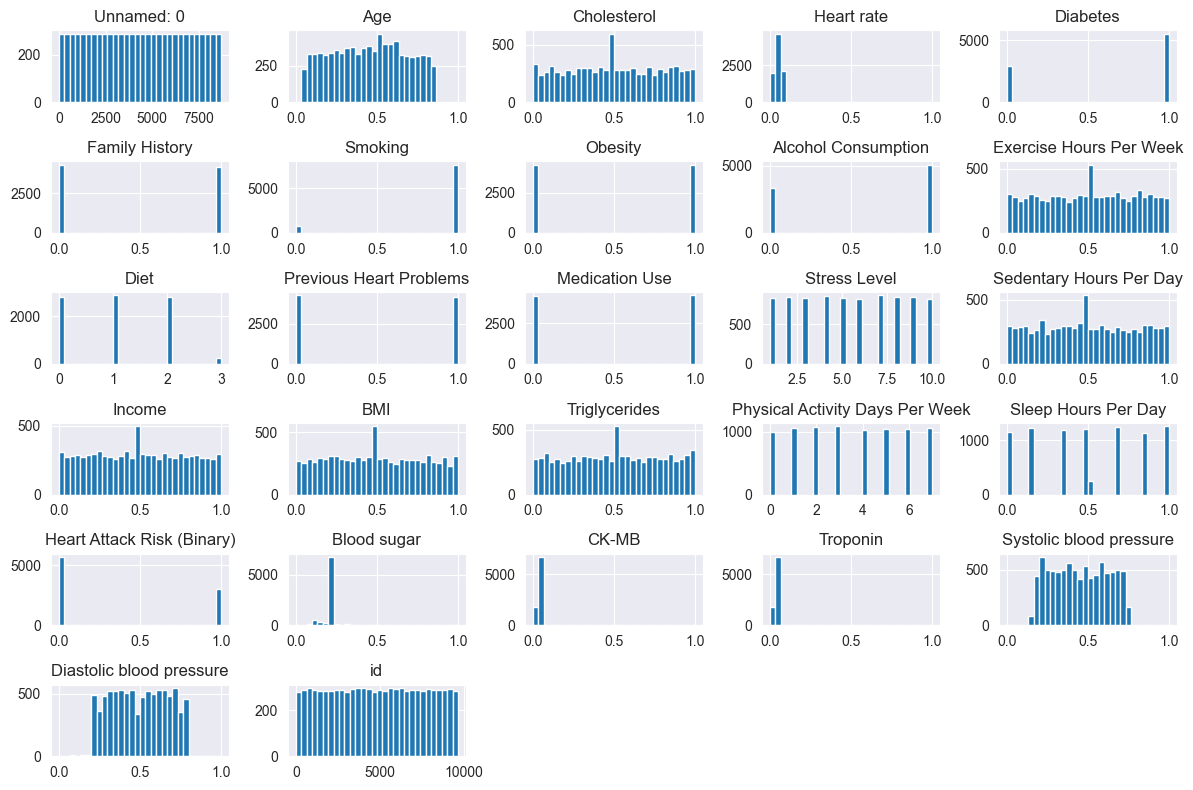


=== TEST быстрый обзор ===
Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.494382  0.224719  0.629213  0.460674   
Cholesterol                      0.264286  0.953571  0.092857  0.567857   
Heart rate                       0.062328  0.082493  0.064161  0.055912   
Diabetes                              0.0       1.0       0.0       1.0   
Family History                        1.0       0.0       1.0       1.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       1.0       1.0       1.0   
Alcohol Consumption                   1.0       0.0       0.0       1.0   
Exercise Hours Per Week          0.361618  0.996483  0.995561  0.437277   
Diet                                    2         2         0         0   
Previous Heart Problems               0.0       1.0       0

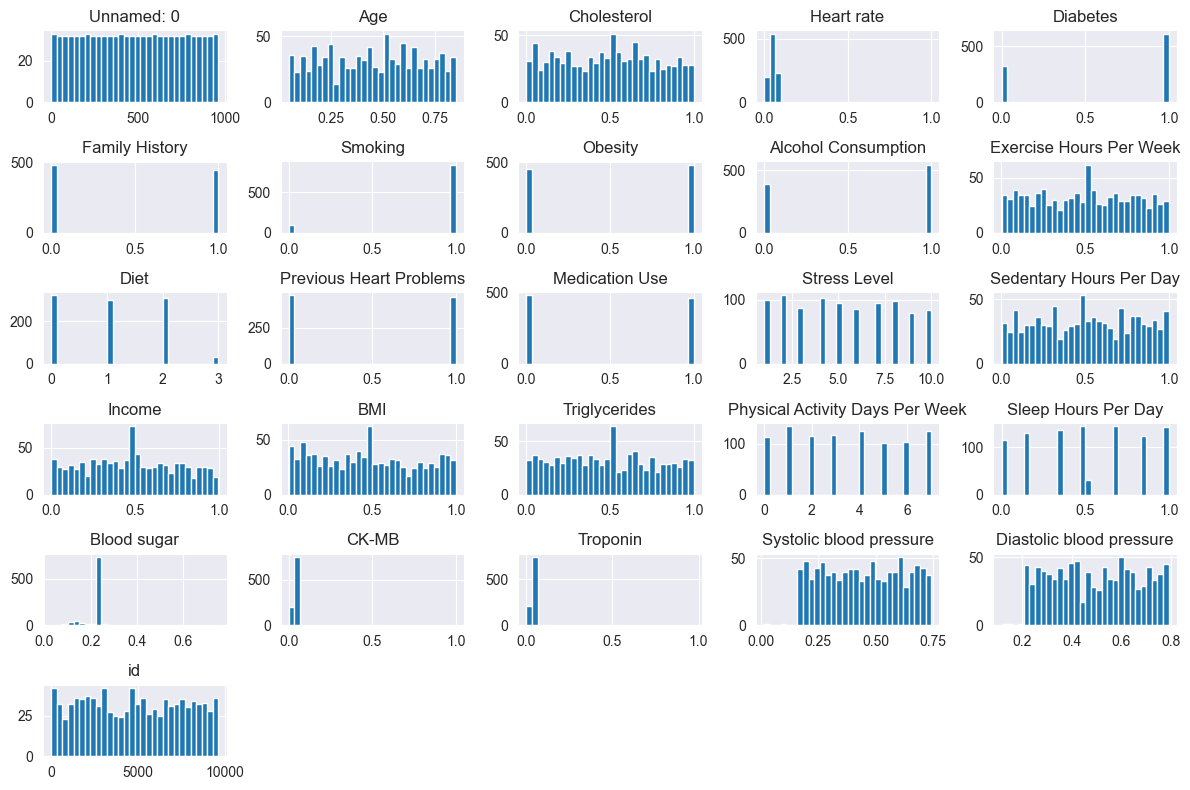

In [34]:
# Рассмотрим датасеты

# === Настройки путей ===
DATA_DIR = Path.cwd().parent / "data"

TRAIN_PATH = DATA_DIR / "heart_train.csv"
TEST_PATH  = DATA_DIR / "heart_test.csv"
TARGET = "Heart Attack Risk (Binary)"  # точное имя таргета из train

# === Загрузка данных ===
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# === Быстрый обзор train ===
print("=== TRAIN быстрый обзор ===")
quick_overview(train_df, target=TARGET)

print("\n=== TRAIN детали ===")
quick_details(train_df, target=TARGET, max_unique=10)

print("\n=== TRAIN графики ===")
quick_plots(train_df)
plt.tight_layout()
plt.show()

# === Быстрый обзор test (без таргета) ===
print("\n=== TEST быстрый обзор ===")
quick_overview(test_df)  # таргета в test нет

print("\n=== TEST детали ===")
quick_details(test_df, max_unique=10)

print("\n=== TEST графики ===")
quick_plots(test_df)
plt.tight_layout()
plt.show()



# Первичные выводы по датасетам

###  Перечень признаков
- **Unnamed: 0** — служебный индекс из исходного файла (не несёт смысловой нагрузки)
- **Age** — возраст пациента (в нормализованном виде)
- **Cholesterol** — уровень холестерина
- **Heart rate** — частота сердечных сокращений
- **Diabetes** — наличие диабета (`1` — да, `0` — нет)
- **Family History** — наличие семейной истории сердечных заболеваний (`1` — да, `0` — нет)
- **Smoking** — курение (`1` — да, `0` — нет)
- **Obesity** — ожирение (`1` — да, `0` — нет)
- **Alcohol Consumption** — потребление алкоголя (возможно, в нормализованной шкале)
- **Exercise Hours Per Week** — количество часов физической активности в неделю
- **Diet** — качество диеты (в нормализованном виде)
- **Previous Heart Problems** — наличие ранее диагностированных сердечных заболеваний (`1` — да, `0` — нет)
- **Medication Use** — приём лекарственных препаратов (`1` — да, `0` — нет)
- **Stress Level** — уровень стресса
- **Sedentary Hours Per Day** — количество часов сидячего образа жизни в день
- **Income** — доход (в нормализованном виде)
- **BMI** — индекс массы тела
- **Triglycerides** — уровень триглицеридов
- **Physical Activity Days Per Week** — количество дней в неделю с физической активностью
- **Sleep Hours Per Day** — количество часов сна в день
- **Heart Attack Risk (Binary)** — целевая переменная: риск сердечного приступа (`1` — высокий, `0` — низкий)
  *(есть только в train, в test отсутствует)*
- **Blood sugar** — уровень сахара в крови
- **CK-MB** — уровень фермента CK-MB (маркер повреждения сердца)
- **Troponin** — уровень тропонина (маркер повреждения сердца)
- **Gender** — пол пациента (`Male` / `Female`)
- **Systolic blood pressure** — систолическое артериальное давление
- **Diastolic blood pressure** — диастолическое артериальное давление
- **id** — уникальный идентификатор пациента

### Короткий отчёт по первичному обзору датасетов

**1. Общая структура**
- Train: 8685 строк × 28 колонок (включая таргет)
- Test: 966 строк × 27 колонок (без таргета)
- Типы данных: в основном `float64`, немного `int64`, 1 `object` (`Gender`)
- Дубликатов нет

**2. Пропуски**
- Одинаковый набор признаков с ~2.8% пропусков в train и ~3.2% в test:
  `Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`,
  `Previous Heart Problems`, `Medication Use`, `Stress Level`,
  `Physical Activity Days Per Week`

**3. Категориальные признаки**
- `Gender` — смешанные форматы (`Male`/`Female` и `0.0`/`1.0`), требуется нормализация
- `Diet` — числовой код (0–3), вероятно категориальная шкала
- Остальные бинарные признаки — 0/1 + пропуски

**4. Нормализация и диапазоны**
- Большинство числовых признаков приведены к диапазону [0, 1] (min–max scaling)
- Дискретные значения в оригинальном диапазоне: `Stress Level` (1–10),
  `Physical Activity Days Per Week` (0–7)
- `Heart rate`, `Blood sugar` имеют выраженные пики на малых значениях
- `CK-MB`, `Troponin` — крайне скошенные распределения, большинство значений ≈0

**5. Баланс таргета (train)**
- 0: 65.3%, 1: 34.7% — умеренный дисбаланс

**6. Корреляции с таргетом**
- Линейные корреляции очень низкие (max ≈ 0.034 для `Systolic blood pressure`)
- Прямая линейная предсказуемость слабая, нужны модели, учитывающие нелинейности и взаимодействия

**7. Наблюдения по гистограммам**
- `Diabetes`, `Smoking`, `Obesity`, `Alcohol Consumption`,
  `Previous Heart Problems`, `Medication Use` — сильный перекос в сторону одного класса
- `Stress Level` и `Physical Activity Days Per Week` — равномерные или почти равномерные распределения по дискретным уровням
- `Sleep Hours Per Day` — несколько фиксированных значений, скорее всего закодированные категории/интервалы сна
- `Gender` — доминирует класс Male
- В тесте распределения очень похожи на train, но у ряда признаков (`Diet`, `Stress Level`) есть перестановка частот отдельных значений
- Много признаков имеют резкие пики (дискретность или предобработка), что надо учесть при фичеинжиниринге

**8. Потенциальные проблемы**
**Утечки**
- **Troponin** — диагностический биомаркер инфаркта миокарда; повышается *после* повреждения сердца. Использование даёт модели фактическое знание о событии.
- **CK-MB** — фермент, растущий при некрозе миокарда; так же измеряется при подозрении/после события. Практически прямой индикатор исхода.
- **Previous Heart Problems** — наличие ранее диагностированных сердечных болезней. По смыслу почти «ярлык класса» и напрямую связан с высокой вероятностью нового события.
- **Medication Use** — приём кардио-лекарств часто назначается после диагноза (ИБС/гипертония/дислипидемия). Это маркер известного заболевания, а не чистый фактор риска.

**Возможные прокси-утечки**
- **Triglycerides** — лабораторный показатель, который могут снимать в остром эпизоде/госпитализации; при неизвестной временной привязке может косвенно сигналить об уже случившемся событии/лечении.
- **Blood sugar** — глюкоза повышается при остром стрессе/инфаркте и часто измеряется в момент обращения; без гарантии замера перед инфарктом становится прокси информации о событии.

**Дополнительная задача**
- Непоследовательная кодировка категорий (`Gender`)



# EDA

1) Загрузка и первичная чистка
   - Удалить технические столбцы (`Unnamed: 0`), они не несут информации и могут «шуметь».
   - Сохранить `id` и проверить его уникальность — нужен для последующего сшивания предсказаний.
   *(Функции: drop_technical_cols, проверка id внутри fit_report)*

2) Приведение типов и кодировок
   - Перекодировать `Gender` в {0,1}; очистить смешанные значения (`'Male'/'Female'` и `0/1`) — иначе модели и корреляции будут работать некорректно.
   *(Функция: encode_gender)*

3) Пропуски: диагностика и импутация
   - В медданных пропуск очень часто может быть содержательно значим: пациент не отвечал/показатель не измеряли. Поэтому **добавляем индикаторы** `*_was_nan`.
   - Импутация: бинарные → мода, порядковые/малоуникальные (`Stress Level`, `Physical Activity Days Per Week`, `Diet`) → округлённая медиана, непрерывные → медиана. Это даёт устойчивую точку отсчёта без утечки таргета.
   *(Функции: report_missing, flag_and_impute_missing)*

4) Поиск подозрительных «пиков» распределений
   - Зафиксировать признаки с резкими пиками в окрестности 0/0.5/1 (следствие предобработки/категоризации). Пометить их для последующего фичеинжиниринга.
   *(Функция: detect_suspicious_peaks)*

5) Маркировка утечек и прокси-утечек
   - Явные утечки: `Troponin`, `CK-MB`, `Previous Heart Problems`, `Medication Use` — **исключать из обучения** (но сохранять для анализа).
   - Прокси-утечки: `Triglycerides`, `Blood sugar` — **не удаляем на EDA**, будем сравнивать метрики «с ними/без них» на этапе моделирования.
   *(Функция: separate_feature_sets)*

6) Корреляции и мультиколлинеарность
   - Построить матрицу корреляций **Spearman** (лучше для порядковых/не-нормальных), с цветовой шкалой сбоку и числовыми подписями в ячейках — быстро видно группы высокозависимых признаков.
   - Оценить VIF и выписать признаки с VIF≫10 как кандидатов на исключение/регуляризацию.
   *(Функции: corr_heatmap, vif_report)*

7) Согласованность train/test
   - Сравнить распределения (числовые и категориальные) между train и test, чтобы заметить возможный дрифт/рассинхрон частот. Если отличаются — пометить для робастного препроцесса.
   *(Функция: train_test_alignment — при необходимости)*

8) Вывод и фиксация решений
   - Сформировать краткий Markdown-итог: что удалено, как кодирован `Gender`, как обрабатывались пропуски, какие «пики» найдены, какие пары скоррелированы, какие признаки — утечки/прокси, кто имеет высокий VIF.
   *(Функция: summarize_eda_findings / summary_md из fit_report)*

> Результат: подготовленные `train_clean/test_clean`, сохранённые `ids`, списки `safe_cols/proxy_cols/leakage_cols`, отчёты по пропускам/пикам/корреляциям/VIF. Это даёт чистую базу для фичеинжиниринга и честного сравнения моделей (с прокси и без).


In [35]:
# Класс EDA
class EDAHelper:
    """
    Помощник для EDA под проект М1.
    Делает:
      - удаление технич. колонок, сохранение id
      - перекодировку Gender -> {0,1}
      - отчёт/импутацию пропусков + индикаторы _was_nan
      - поиск пиков (автоматически по гистограмме)
      - разбиение фичей на safe / proxy / leakage
      - heatmap корреляций
      - отчёт по VIF
      - распределение таргета по классам
      - распределение таргета по признакам (таблицы + графики)
      - проверку утечки ID между train/test
      - fit_report(train, test): оркестратор + markdown-вывод
    """

    def __init__(
        self,
        target: str = "Heart Attack Risk (Binary)",
        id_col: str = "id",
        technical_cols: tuple = ("Unnamed: 0",),
        leakage_cols: tuple = ("Troponin", "CK-MB", "Previous Heart Problems", "Medication Use"),
        proxy_cols: tuple = ("Triglycerides", "Blood sugar"),
        ordinal_cols_guess: tuple = ("Stress Level", "Physical Activity Days Per Week", "Diet"),
        gender_col: str = "Gender",
        gender_map: dict = None,
    ):
        # Храним ключевые имена колонок/наборы
        self.target = target
        self.id_col = id_col
        self.technical_cols = technical_cols
        self.leakage_cols = tuple(leakage_cols)
        self.proxy_cols = tuple(proxy_cols)
        self.ordinal_cols_guess = tuple(ordinal_cols_guess)
        self.gender_col = gender_col
        self.gender_map = gender_map or {"male": 1, "female": 0, "m": 1, "f": 0}

        # Полезное состояние после fit_report
        self.ids_train = None
        self.ids_test = None
        self.missing_report_train = None
        self.missing_report_test = None
        self.vif_table = None
        self.peaks_table = None
        self.outliers_table = None
        self.corr_matrix = None
        self.summary_md = None
        self.target_dist = None            # распределение таргета по классам (train)
        self.id_check = None               # проверка уникальности и пересечения id
        self.target_by_cats = None         # таблица: таргет по категориальным/порядковым/флагам was_nan
        self.target_by_quants = None       # таблица: таргет по квантилям непрерывных

    # ---------- ВСПОМОГАТЕЛЬНЫЕ МЕТОДЫ ТИПОВ ----------

    def _numeric_cols(self, df: pd.DataFrame) -> list:
        """Возвращает список числовых признаков, исключая id и таргет."""
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        return [c for c in cols if c not in (self.id_col, self.target)]

    def _binary_cols(self, df: pd.DataFrame) -> list:
        """Ищет бинарные признаки: уникальные значения подмножеством {0,1} (без NaN)."""
        out = []
        for c in self._numeric_cols(df):
            vals = set(pd.Series(df[c].dropna().unique()).tolist())
            if vals and vals.issubset({0, 1, 0.0, 1.0}):
                out.append(c)
        return out

    def _ordinal_cols(self, df: pd.DataFrame) -> list:
        """Ищет очевидные порядковые признаки по именам (простая эвристика)."""
        present = [c for c in self.ordinal_cols_guess if c in df.columns]
        return present

    def _small_cardinality_numeric(self, df: pd.DataFrame, max_unique: int = 10) -> list:
        """Числовые признаки с малым числом уникальных значений (могут быть категориальные/порядковые)."""
        out = []
        for c in self._numeric_cols(df):
            nuniq = df[c].nunique(dropna=True)
            if nuniq <= max_unique:
                out.append(c)
        return out

    # ---------- ПОДГОТОВКА ДАННЫХ ----------

    def drop_technical_cols(self, df: pd.DataFrame) -> pd.DataFrame:
        """Удаляет служебные столбцы (например, 'Unnamed: 0'), но НЕ трогает id."""
        tech = [c for c in df.columns if c in self.technical_cols or re.match(r"^Unnamed", c or "", flags=re.I)]
        return df.drop(columns=tech, errors="ignore")

    def encode_gender(self, df: pd.DataFrame) -> pd.DataFrame:
        """Перекодирует Gender в {0,1}; чистит смешанные значения ('0.0','1.0', строки)."""
        if self.gender_col not in df.columns:
            return df
        ser = df[self.gender_col]
        as_str = ser.astype(str).str.strip().str.lower()
        mapped = as_str.map(self.gender_map)
        unmapped_mask = mapped.isna()
        if unmapped_mask.any():
            as_num = pd.to_numeric(as_str, errors="coerce")
            as_num = as_num.where(as_num.isin([0, 1]), np.nan)
            mapped = mapped.where(~unmapped_mask, as_num)
        df[self.gender_col] = mapped.astype("float").astype("Int64").astype("float").fillna(np.nan)
        return df

    def report_missing(self, df: pd.DataFrame) -> pd.Series:
        """Возвращает серию с количеством пропусков по колонкам (сортировка по убыванию)."""
        return df.isnull().sum().sort_values(ascending=False)

    def flag_and_impute_missing(
        self,
        df: pd.DataFrame,
        binary_cols: list | None = None,
        ordinal_cols: list | None = None,
    ) -> pd.DataFrame:
        """
        Создаёт индикаторы пропусков *_was_nan и заполняет пропуски:
          - бинарные -> мода
          - порядковые -> медиана (округлённая)
          - другие числовые -> медиана
        Объектные/строковые колонки не трогаем.
        """
        df = df.copy()
        numeric_cols = self._numeric_cols(df)
        binary_cols = binary_cols or self._binary_cols(df)
        ordinal_cols = ordinal_cols or self._ordinal_cols(df)

        for c in numeric_cols:
            if df[c].isna().any():
                df[f"{c}_was_nan"] = df[c].isna().astype(int)
                if c in binary_cols:
                    mode_val = df[c].mode(dropna=True)
                    fill_val = float(mode_val.iloc[0]) if not mode_val.empty else 0.0
                    df[c] = df[c].fillna(fill_val).clip(0, 1)
                elif c in ordinal_cols or c in self._small_cardinality_numeric(df):
                    med = df[c].median(skipna=True)
                    df[c] = df[c].fillna(round(med))
                else:
                    med = df[c].median(skipna=True)
                    df[c] = df[c].fillna(med)
        return df

    # ---------- ПИКИ / ВЫБРОСЫ ----------

    def detect_peaks_auto(
        self,
        df: pd.DataFrame,
        bins: str | int = "fd",
        min_share: float = 0.03,
        prominence: float = 2.0,
        top_k: int = 3,
        skip_missing_indicators: bool = True,
        skip_binary: bool = True,
        min_unique: int = 11,
        as_percent: bool = True,
        decimals: int = 2
    ) -> pd.DataFrame:
        """
        Автопоиск локальных пиков по гистограмме без заранее заданных значений.
        Пик = столбик гистограммы, превышающий соседей и медиану ненулевых частот * 'prominence'.
        Возвращает центры бинов и доли/проценты наблюдений в них.
        """
        cols = self._numeric_cols(df)
        if skip_missing_indicators:
            cols = [c for c in cols if not c.endswith("_was_nan")]
        if skip_binary:
            tmp = []
            for c in cols:
                vals = df[c].dropna().unique()
                if len(vals) <= 2 and set(vals).issubset({0, 1}):
                    continue
                if df[c].nunique(dropna=True) < min_unique:
                    continue
                tmp.append(c)
            cols = tmp

        rows = []
        for c in cols:
            s = df[c].dropna().values
            if s.size < 5:
                continue
            counts, edges = np.histogram(s, bins=bins)
            if counts.sum() == 0:
                continue
            nz = counts[counts > 0]
            med = np.median(nz) if nz.size else 0
            n = int(s.size)
            for i in range(1, len(counts) - 1):
                left, mid, right = counts[i-1], counts[i], counts[i+1]
                if mid > left and mid > right and mid >= med * prominence:
                    share = mid / n
                    if share >= min_share:
                        center = (edges[i] + edges[i+1]) / 2
                        rows.append({
                            "feature": c,
                            "bin_center": float(center),
                            "bin_left": float(edges[i]),
                            "bin_right": float(edges[i+1]),
                            "count": int(mid),
                            "pct_in_bin": round(share * 100, decimals) if as_percent else share,
                        })
        peaks = pd.DataFrame(rows)
        if peaks.empty:
            return peaks
        key = "pct_in_bin" if as_percent else "count"
        peaks = peaks.sort_values(["feature", key], ascending=[True, False])
        peaks = peaks.groupby("feature").head(top_k).reset_index(drop=True)
        return peaks

    def detect_outliers(
        self,
        df: pd.DataFrame,
        method: str = "iqr",
        iqr_factor: float = 1.5,
        mad_z: float = 3.5,
        skip_missing_indicators: bool = True,
        skip_binary: bool = True,
        min_unique: int = 11,
        as_percent: bool = True,
        decimals: int = 2
    ) -> pd.DataFrame:
        """
        Короткий отчёт по выбросам.
        - IQR: границы [Q1 - k*IQR, Q3 + k*IQR]
        - MAD: |x - median| / (1.4826*MAD) > mad_z
        """
        cols = self._numeric_cols(df)
        if skip_missing_indicators:
            cols = [c for c in cols if not c.endswith("_was_nan")]
        if skip_binary:
            tmp = []
            for c in cols:
                vals = df[c].dropna().unique()
                if len(vals) <= 2 and set(vals).issubset({0, 1}):
                    continue
                if df[c].nunique(dropna=True) < min_unique:
                    continue
                tmp.append(c)
            cols = tmp

        rows = []
        for c in cols:
            s = df[c].dropna().values
            n = s.size
            if n < 5:
                continue
            if method.lower() == "mad":
                med = np.median(s)
                mad = np.median(np.abs(s - med))
                denom = (1.4826 * mad) if mad > 0 else np.inf
                z = np.abs(s - med) / denom
                mask = z > mad_z
                lower, upper = None, None
            else:
                q1, q3 = np.percentile(s, [25, 75])
                iqr = q3 - q1
                lower = q1 - iqr_factor * iqr
                upper = q3 + iqr_factor * iqr
                mask = (s < lower) | (s > upper)
            share = mask.mean()
            if share == 0:
                continue
            rows.append({
                "Признак": c,
                "N": int(n),
                "% выбросов": round(share * 100, decimals) if as_percent else share,
                "Нижняя граница": None if lower is None else float(lower),
                "Верхняя граница": None if upper is None else float(upper),
                "Мин. выброс": float(np.min(s[mask])) if mask.any() else None,
                "Макс. выброс": float(np.max(s[mask])) if mask.any() else None,
            })
        return pd.DataFrame(rows).sort_values("% выбросов" if as_percent else "N", ascending=False)

    # ---------- РАСПРЕДЕЛЕНИЕ ТАРГЕТА (общая, по признакам) / ПРОВЕРКА ID ----------

    def target_distribution(self, df: pd.DataFrame) -> pd.DataFrame:
        """Возвращает распределение таргета по классам (train): 'Класс', 'Количество', '%'."""
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден в DataFrame.")
        vc = df[self.target].value_counts().sort_index()
        n = int(vc.sum())
        out = pd.DataFrame({
            "Класс": vc.index.astype(int),
            "Количество": vc.values,
            "%": (vc.values / n * 100).round(2)
        }).reset_index(drop=True)
        return out

    def target_rate_by(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        include_proxy: bool = False,
        include_missing_indicators: bool = True,
        max_levels: int = 20
    ) -> pd.DataFrame:
        """
        Таблица долей класса=1 по группам для категориальных/порядковых/бинарных признаков.
        - По умолчанию исключает явные утечки; прокси можно включить флагом.
        - Флаги *_was_nan по умолчанию ВКЛЮЧЕНЫ (важно для понимания роли пропусков).
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        # авто-выбор, если cols не задан
        use_cols = []
        if cols is None:
            base = self._binary_cols(df) + self._ordinal_cols(df) + ([self.gender_col] if self.gender_col in df.columns else [])
            if include_missing_indicators:
                base += [c for c in df.columns if isinstance(c, str) and c.endswith("_was_nan")]
            use_cols = list(dict.fromkeys([c for c in base if c in df.columns]))
        else:
            use_cols = [c for c in cols if c in df.columns]
            if include_missing_indicators:
                use_cols += [c for c in df.columns if isinstance(c, str) and c.endswith("_was_nan")]
                use_cols = list(dict.fromkeys(use_cols))

        # исключаем утечки; прокси по флагу
        use_cols = [c for c in use_cols if c not in self.leakage_cols]
        if not include_proxy:
            use_cols = [c for c in use_cols if c not in self.proxy_cols]
        if not use_cols:
            return pd.DataFrame(columns=["Признак", "Значение", "N", "% класса=1"])

        rows = []
        for c in use_cols:
            vc = df[c].value_counts(dropna=False)
            kept = set(vc.head(max_levels).index.tolist())
            dfx = df.copy()
            dfx[c] = dfx[c].where(dfx[c].isin(kept), other="__Другое__")
            grp = dfx.groupby(c, dropna=False)[self.target].agg(rate="mean", n="count").reset_index()
            for _, r in grp.iterrows():
                rows.append({
                    "Признак": c,
                    "Значение": r[c],
                    "N": int(r["n"]),
                    "% класса=1": round(float(r["rate"]) * 100, 2)
                })
        out = pd.DataFrame(rows).sort_values(["Признак", "% класса=1"], ascending=[True, False]).reset_index(drop=True)
        return out

    def risk_by_quantiles(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        q: int = 10,
        include_proxy: bool = False
    ) -> pd.DataFrame:
        """
        Таблица долей класса=1 по квантилям непрерывных признаков.
        - Исключает явные утечки и *_was_nan; прокси можно включить флагом.
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        # авто-выбор, если cols не задан
        if cols is None:
            num = [c for c in self._numeric_cols(df) if not c.endswith("_was_nan") and c not in self.leakage_cols]
            if not include_proxy:
                num = [c for c in num if c not in self.proxy_cols]
            # оставим «небинарные» и достаточно разнообразные
            def is_cont(col):
                s = df[col]
                return s.dropna().nunique() >= max(11, q) and not set(s.dropna().unique()).issubset({0, 1})
            cols = [c for c in num if is_cont(c)]

        rows = []
        for c in cols:
            s = df[c]
            if s.dropna().nunique() < max(5, q):
                continue
            try:
                bins = pd.qcut(s, q=q, duplicates="drop")
            except Exception:
                continue
            grp = df.groupby(bins, dropna=True, observed=False)[self.target].agg(rate="mean", n="count").reset_index()
            for _, r in grp.iterrows():
                iv = r[c]
                rows.append({
                    "Признак": c,
                    "Квантиль": str(iv),
                    "Мин": float(iv.left),
                    "Макс": float(iv.right),
                    "N": int(r["n"]),
                    "% класса=1": round(float(r["rate"]) * 100, 2)
                })
        out = pd.DataFrame(rows).sort_values(["Признак", "Квантиль"]).reset_index(drop=True)
        return out

    def check_id_integrity(self, train: pd.DataFrame, test: pd.DataFrame) -> dict:
        """
        Проверка ID:
          - уникальность id в train и test
          - пересечение id между выборками (утечка)
        Возвращает словарь с подсчётами и примером пересечений (до 10 шт).
        """
        if self.id_col not in train.columns or self.id_col not in test.columns:
            return {"ok": False, "msg": f"Колонка id '{self.id_col}' не найдена в одной из выборок."}
        tr_ids = train[self.id_col]; ts_ids = test[self.id_col]
        dup_train = int(tr_ids.duplicated().sum()); dup_test = int(ts_ids.duplicated().sum())
        inter = set(tr_ids.tolist()).intersection(set(ts_ids.tolist()))
        return {
            "ok": (dup_train == 0 and dup_test == 0 and len(inter) == 0),
            "train_ids": int(tr_ids.nunique()),
            "test_ids": int(ts_ids.nunique()),
            "dup_train": dup_train,
            "dup_test": dup_test,
            "intersection": len(inter),
            "intersection_sample": list(sorted(inter))[:10],
        }

    # ---------- КОРРЕЛЯЦИИ / VIF ----------

    def corr_heatmap(
        self,
        df: pd.DataFrame,
        method: str = "spearman",
        figsize: tuple = (12, 10),
        annot: bool = True,
        fmt: str = ".2f",
        cbar: bool = True,
        vmax: float | None = None,
        include_missing_indicators: bool = False,
        annot_size: int = 7,
        show: bool = True,
    ) -> pd.DataFrame:
        """
        Теплокарта корреляций. По умолчанию ИСКЛЮЧАЕТ *_was_nan,
        чтобы не засорять матрицу корреляций.
        """
        num_cols = self._numeric_cols(df) + ([self.target] if self.target in df.columns else [])
        if not include_missing_indicators:
            num_cols = [c for c in num_cols if not c.endswith("_was_nan")]
        mat = df[num_cols].corr(method=method)
        if show:
                plt.figure(figsize=figsize)
                sns.heatmap(
                    mat, annot=annot, fmt=fmt, cmap="coolwarm",
                    vmin=-1, vmax=1 if vmax is None else vmax, cbar=cbar,
                    annot_kws={"size": annot_size}
                )
                plt.title(f"Корреляции ({method})")
                plt.tight_layout()
                plt.show()
        return mat

    def vif_report(self, df: pd.DataFrame, drop_cols: list | None = None) -> pd.DataFrame:
        """
        VIF без таргета / id и БЕЗ *_was_nan.
        """
        X = df.copy()
        for col in [self.id_col, self.target]:
            if col in X.columns:
                X = X.drop(columns=col)
        if drop_cols:
            X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")
        X = X[[c for c in X.columns if not c.endswith("_was_nan")]]
        X = X.select_dtypes(include=[np.number]).copy()
        zero_var = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
        X = X.drop(columns=zero_var, errors="ignore")
        if X.shape[1] < 2:
            return pd.DataFrame(columns=["feature", "VIF"])
        vif_rows = []
        for i, col in enumerate(X.columns):
            try:
                vif = variance_inflation_factor(X.values, i)
            except Exception:
                vif = np.nan
            vif_rows.append({"feature": col, "VIF": float(vif)})
        return pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)

    # ---------- ПРОСТЫЕ ВИЗУАЛИЗАЦИИ ТАРГЕТА ПО ПРИЗНАКАМ ----------

    def plot_target_rate_by_cats(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        include_proxy: bool = False,
        include_missing_indicators: bool = True,
        max_levels: int = 8,
        ncols: int = 3,
        height: float = 3.0
    ):
        """
        Рисует компактную панель bar-чартов: доля класса=1 по группам для категориальных/порядковых/флагов *_was_nan.
        По умолчанию исключает явные утечки, прокси — по флагу.
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        # авто-выбор
        use = cols if cols is not None else list(set(
            self._binary_cols(df) + self._ordinal_cols(df) + ([self.gender_col] if self.gender_col in df.columns else [])
        ))
        if include_missing_indicators:
            use += [c for c in df.columns if isinstance(c, str) and c.endswith("_was_nan")]
        use = [c for c in use if c in df.columns and c not in self.leakage_cols]
        if not include_proxy:
            use = [c for c in use if c not in self.proxy_cols]
        if not use:
            print("Нет подходящих категориальных/порядковых признаков для графиков.")
            return

        n = len(use); ncols = max(1, ncols); nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, height*nrows), squeeze=False)
        ax_iter = (ax for row in axes for ax in row)

        for c, ax in zip(use, ax_iter):
            vc = df[c].value_counts(dropna=False)
            keep = set(vc.head(max_levels).index.tolist())
            dfx = df.copy()
            dfx[c] = dfx[c].where(dfx[c].isin(keep), other="__Другое__")
            grp = dfx.groupby(c, dropna=False, observed=False)[self.target].agg(rate="mean", n="count").reset_index()
            grp = grp.sort_values("rate", ascending=False)
            ax.bar(grp[c].astype(str), grp["rate"]*100)
            ax.set_title(f"{c} (N={int(df[c].notna().sum())})", fontsize=10)
            ax.set_ylabel("% класса=1"); ax.set_xlabel("")
            ax.tick_params(axis="x", labelrotation=30)

        for ax in ax_iter:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    def plot_box_by_target(
        self,
        df: pd.DataFrame,
        cols: list | None = None,
        include_proxy: bool = False,
        ncols: int = 3,
        height: float = 3.0,
        max_plots: int = 9
    ):
        """
        Рисует компактную панель boxplot'ов: непрерывные фичи vs таргет (0/1).
        Исключает явные утечки и *_was_nan; прокси — по флагу.
        """
        if self.target not in df.columns:
            raise ValueError(f"Таргет '{self.target}' не найден.")
        num = [c for c in self._numeric_cols(df) if not c.endswith("_was_nan") and c not in self.leakage_cols]
        if not include_proxy:
            num = [c for c in num if c not in self.proxy_cols]

        def is_cont(col):
            s = df[col]
            return s.dropna().nunique() >= 11 and not set(s.dropna().unique()).issubset({0, 1})

        use = [c for c in (cols if cols else num) if c in df.columns and is_cont(c)]
        if not use:
            print("Нет подходящих непрерывных признаков для boxplot.")
            return
        use = use[:max_plots]

        n = len(use); ncols = max(1, ncols); nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, height*nrows), squeeze=False)
        ax_iter = (ax for row in axes for ax in row)

        df_ = df.copy()
        df_[self.target] = df_[self.target].astype(int).astype(str)

        for c, ax in zip(use, ax_iter):
            sns.boxplot(data=df_, x=self.target, y=c, ax=ax)
            ax.set_title(c, fontsize=10)
            ax.set_xlabel("Класс таргета"); ax.set_ylabel(c)

        for ax in ax_iter:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    # ---------- ФИЧЕ-СЕТЫ ----------

    def separate_feature_sets(self, df: pd.DataFrame) -> dict:
        """
        Разделяет фичи на:
          - safe_cols: все числовые признаки БЕЗ leakage (proxy пока остаются)
          - proxy_cols: пересечение датасета с заданным списком прокси
          - leakage_cols: пересечение датасета с заданным списком утечек
        Возвращает словарь с тремя списками имён колонок.
        """
        all_num = self._numeric_cols(df)
        leakage_present = [c for c in self.leakage_cols if c in df.columns]
        proxy_present = [c for c in self.proxy_cols if c in df.columns]
        safe_cols = [c for c in all_num if c not in leakage_present]
        return {"safe_cols": safe_cols, "proxy_cols": proxy_present, "leakage_cols": leakage_present}

    # ---------- ГЛАВНЫЙ ПАЙПЛАЙН ----------

    def fit_report(self, train: pd.DataFrame, test: pd.DataFrame) -> dict:
        """
        Полный цикл EDA-подготовки (ничего лишнего не рисует автоматически).
        """
        # 1) Технич. столбцы
        tr = self.drop_technical_cols(train); ts = self.drop_technical_cols(test)
        # 2) Gender
        tr = self.encode_gender(tr); ts = self.encode_gender(ts)
        # 3) ID
        if self.id_col in tr.columns: self.ids_train = tr[self.id_col].copy()
        if self.id_col in ts.columns: self.ids_test  = ts[self.id_col].copy()
        self.id_check = self.check_id_integrity(tr, ts)
        # 4) Пропуски + импутация
        self.missing_report_train = self.report_missing(tr); self.missing_report_test = self.report_missing(ts)
        tr = self.flag_and_impute_missing(tr); ts = self.flag_and_impute_missing(ts)
        # 5) Пики/выбросы
        self.peaks_table = self.detect_peaks_auto(tr, bins="fd", min_share=0.03, prominence=2.0, top_k=3)
        self.outliers_table = self.detect_outliers(tr, method="iqr", iqr_factor=1.5)
        # 6) Корреляции
        self.corr_matrix = self.corr_heatmap(tr, method="spearman", annot=True, cbar=True, show=False)
        # 7) VIF (на safe)
        feat_sets = self.separate_feature_sets(tr)
        vif_base = tr[[c for c in feat_sets["safe_cols"] if c != self.target]].copy()
        self.vif_table = self.vif_report(vif_base)
        # 7b) Распределения таргета (числа)
        self.target_dist = self.target_distribution(tr)
        self.target_by_cats = self.target_rate_by(tr, include_proxy=False, include_missing_indicators=True)
        self.target_by_quants = self.risk_by_quantiles(tr, cols=None, q=10, include_proxy=False)
        # 8) Фиче-наборы
        feature_sets = self.separate_feature_sets(tr)
        # 9) Саммари
        self.summary_md = self._build_summary_md(train, test, feature_sets)

        out = {
            "train_clean": tr.copy(),
            "test_clean": ts.copy(),
            "ids_train": self.ids_train,
            "ids_test": self.ids_test,
            "feature_sets": feature_sets,
            "reports": {
                "missing_train": self.missing_report_train,
                "missing_test": self.missing_report_test,
                "peaks": self.peaks_table,
                "outliers": self.outliers_table,
                "corr_matrix": self.corr_matrix,
                "vif": self.vif_table,
                "target_distribution": self.target_dist,
                "target_by_cats": self.target_by_cats,
                "target_by_quantiles": self.target_by_quants,
                "id_check": self.id_check,
                "summary_md": self.summary_md,
            },
        }
        return out

    # ---------- САММАРИ ----------

    def _build_summary_md(self, train_raw: pd.DataFrame, test_raw: pd.DataFrame, feature_sets: dict) -> str:
        """Генерирует короткий markdown-отчёт по ключевым шагам EDA-подготовки."""
        n_tr, p_tr = train_raw.shape; n_ts, p_ts = test_raw.shape
        miss_tr = self.missing_report_train[self.missing_report_train > 0]
        miss_ts = self.missing_report_test[self.missing_report_test > 0]
        top_vif = (self.vif_table.head(10).to_string(index=False) if self.vif_table is not None else "—")
        peaks = (self.peaks_table.head(15).to_string(index=False)
                 if self.peaks_table is not None and not self.peaks_table.empty else "нет выраженных пиков")

        md = []
        md.append("## Cаммари EDA-подготовки")
        md.append(f"- Исходный размер: train {n_tr}×{p_tr}, test {n_ts}×{p_ts}")
        if self.id_check is not None:
            md.append(f"- ID: дубл. train={self.id_check.get('dup_train', '—')}, "
                      f"дубл. test={self.id_check.get('dup_test', '—')}, "
                      f"пересечение train∩test={self.id_check.get('intersection', '—')}")
        md.append("- Удалены технические столбцы (например, `Unnamed: 0`); `id` сохранён.")
        md.append("- `Gender` перекодирован в {0,1}; смешанные значения нормализованы.")
        if not miss_tr.empty or not miss_ts.empty:
            md.append("- Пропуски обработаны с добавлением индикаторов `*_was_nan`:\n"
                      f"  - Train с NaN: {', '.join(miss_tr.index.tolist()) if not miss_tr.empty else 'нет'}\n"
                      f"  - Test с NaN: {', '.join(miss_ts.index.tolist()) if not miss_ts.empty else 'нет'}")
        else:
            md.append("- Пропусков не обнаружено.")
        if self.target_dist is not None and not self.target_dist.empty:
            dct = dict(zip(self.target_dist["Класс"], self.target_dist["%"]))
            md.append(f"- Таргет: {', '.join([f'{k} → {v}%' for k, v in dct.items()])}")
        md.append("- Автопики по гистограмме (без заранее заданных точек):")
        md.append(f"```\n{peaks}\n```")
        outs = (self.outliers_table.head(10).to_string(index=False)
                if self.outliers_table is not None and not self.outliers_table.empty else "нет выбросов по IQR")
        md.append("- Выбросы (IQR, топ-10):")
        md.append(f"```\n{outs}\n```")
        md.append("- Корреляции: heatmap (Spearman) построен с подписями и шкалой.")
        md.append("- Мультиколлинеарность (VIF, топ-10):")
        md.append(f"```\n{top_vif}\n```")
        md.append("- Разделение признаков:")
        md.append(f"  - Safe: {len(feature_sets.get('safe_cols', []))} шт.")
        md.append(f"  - Proxy (не удаляли на этапе EDA): {', '.join(feature_sets.get('proxy_cols', [])) or '—'}")
        md.append(f"  - Leakage (исключать при обучении): {', '.join(feature_sets.get('leakage_cols', [])) or '—'}")
        return "\n".join(md)


## Итоговый отчёт EDA 

## Cаммари EDA-подготовки
- Исходный размер: train 8685×28, test 966×27
- ID: дубл. train=0, дубл. test=0, пересечение train∩test=0
- Удалены технические столбцы (например, `Unnamed: 0`); `id` сохранён.
- `Gender` перекодирован в {0,1}; смешанные значения нормализованы.
- Пропуски обработаны с добавлением индикаторов `*_was_nan`:
  - Train с NaN: Smoking, Family History, Diabetes, Alcohol Consumption, Previous Heart Problems, Obesity, Medication Use, Stress Level, Physical Activity Days Per Week
  - Test с NaN: Family History, Diabetes, Alcohol Consumption, Obesity, Smoking, Previous Heart Problems, Physical Activity Days Per Week, Stress Level, Medication Use
- Таргет: 0 → 65.31%, 1 → 34.69%
- Автопики по гистограмме (без заранее заданных точек):
```
нет выраженных пиков
```
- Выбросы (IQR, топ-10):
```
    Признак    N  % выбросов  Нижняя граница  Верхняя граница  Мин. выброс  Макс. выброс
Blood sugar 8685       24.57        0.227018         0.227018          0.0           1.0
      CK-MB 8685       24.57        0.048229         0.048229          0.0           1.0
   Troponin 8685       24.57        0.036512         0.036512          0.0           1.0
 Heart rate 8685        0.02       -0.011916         0.112741          1.0           1.0
```
- Корреляции: heatmap (Spearman) построен с подписями и шкалой.
- Мультиколлинеарность (VIF, топ-10):
```
                 feature       VIF
                 Smoking 16.349045
             Blood sugar  8.760502
Diastolic blood pressure  8.391848
 Systolic blood pressure  7.353983
                     Age  5.892728
              Heart rate  5.316620
                  Gender  4.523746
            Stress Level  4.511193
 Exercise Hours Per Week  3.962061
             Cholesterol  3.958615
```
- Разделение признаков:
  - Safe: 30 шт.
  - Proxy (не удаляли на этапе EDA): Triglycerides, Blood sugar
  - Leakage (исключать при обучении): Troponin, CK-MB, Previous Heart Problems, Medication Use

### Проверка ID (train ↔ test)

- Уникальные ID в train: **8685**, дубликаты: **0**  
- Уникальные ID в test: **966**, дубликаты: **0**  
- Пересечение train∩test: **0**

---

### TRAIN · состав фичей (тип / уникальные / пропуски)

,тип,уникальные,пропуски
Age,float64,77,0
Alcohol Consumption,float64,2,0
Alcohol Consumption_was_nan,int64,2,0
BMI,float64,7933,0
Blood sugar,float64,239,0
CK-MB,float64,679,0
Cholesterol,float64,282,0
Diabetes,float64,2,0
Diabetes_was_nan,int64,2,0
Diastolic blood pressure,float64,66,0


### TRAIN · матрица корреляций (Spearman)

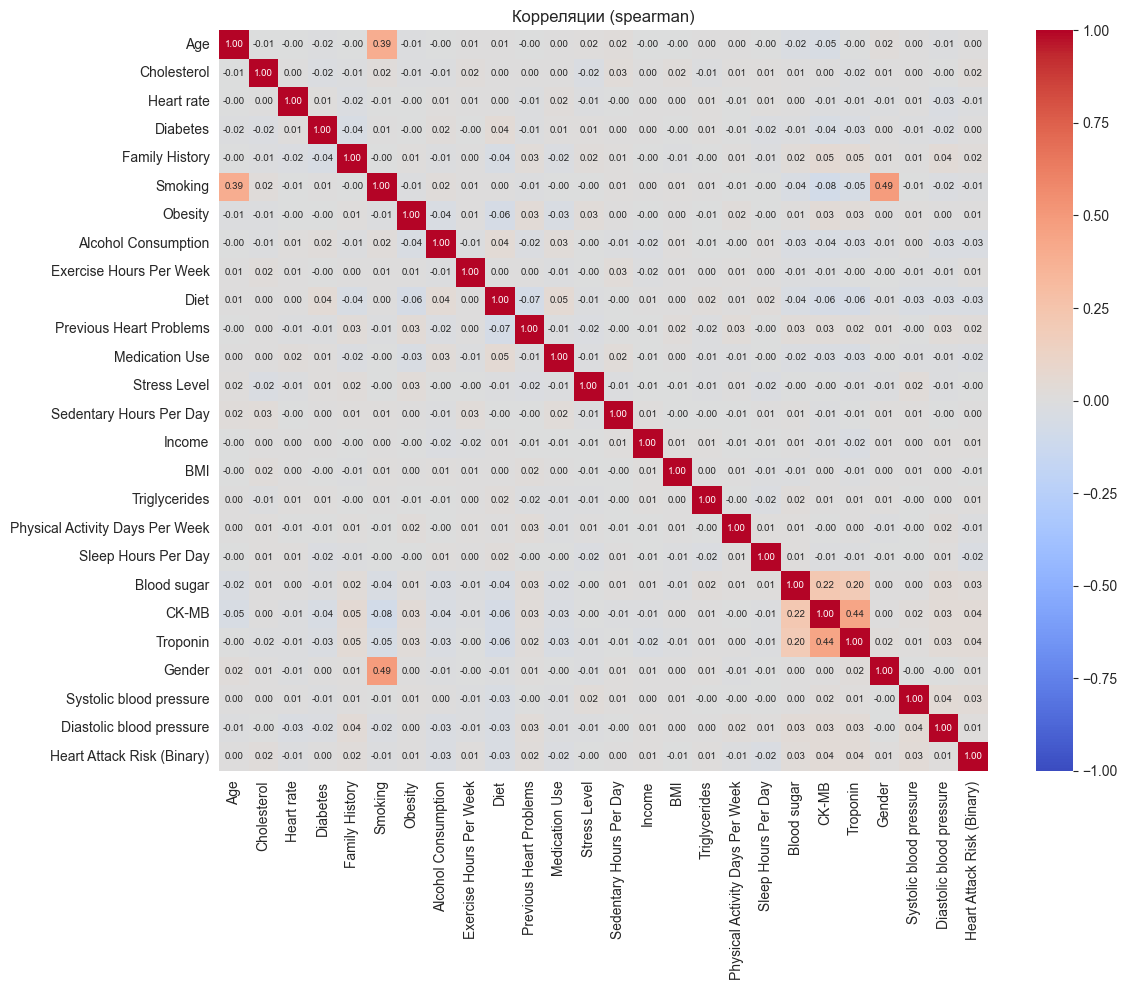

### TRAIN · пропуски (шт)

Smoking                            243
Family History                     243
Diabetes                           243
Alcohol Consumption                243
Previous Heart Problems            243
Obesity                            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

### TRAIN · пики (автопоиск)

""


### TRAIN · выбросы (IQR)

,Признак,N,% выбросов,Нижняя граница,Верхняя граница,Мин. выброс,Макс. выброс
1,Blood sugar,8685,24.57,0.227018,0.227018,0.0,1.0
2,CK-MB,8685,24.57,0.048229,0.048229,0.0,1.0
3,Troponin,8685,24.57,0.036512,0.036512,0.0,1.0
0,Heart rate,8685,0.02,-0.011916,0.112741,1.0,1.0


### TRAIN · таргет: распределение классов

,Класс,Количество,%
0,0,5672,65.31
1,1,3013,34.69


### TRAIN · таргет по категориям и флагам *_was_nan

,Признак,Значение,N,% класса=1
0,Alcohol Consumption,0.0,3360,36.55
1,Alcohol Consumption,1.0,5325,33.52
2,Alcohol Consumption_was_nan,0.0,8442,35.69
3,Alcohol Consumption_was_nan,1.0,243,0.00
4,Diabetes,1.0,5748,34.73
5,Diabetes,0.0,2937,34.63
6,Diabetes_was_nan,0.0,8442,35.69
7,Diabetes_was_nan,1.0,243,0.00
8,Diet,1.0,2863,36.95
9,Diet,2.0,2796,35.23


### TRAIN · таргет по квантилям непрерывных (децили)

,Признак,Квантиль,Мин,Макс,N,% класса=1
0,Age,"(-0.001, 0.124]",-0.001,0.124,902,35.70
1,Age,"(0.124, 0.213]",0.124,0.213,909,35.31
2,Age,"(0.213, 0.292]",0.213,0.292,803,34.74
3,Age,"(0.292, 0.382]",0.292,0.382,970,35.88
4,Age,"(0.382, 0.461]",0.382,0.461,873,31.16
5,Age,"(0.461, 0.528]",0.461,0.528,828,31.52
6,Age,"(0.528, 0.596]",0.528,0.596,804,33.08
7,Age,"(0.596, 0.685]",0.596,0.685,968,36.78
8,Age,"(0.685, 0.775]",0.685,0.775,830,34.22
9,Age,"(0.775, 1.0]",0.775,1.000,798,38.10


### TRAIN · графики: доля класса=1 по категориям

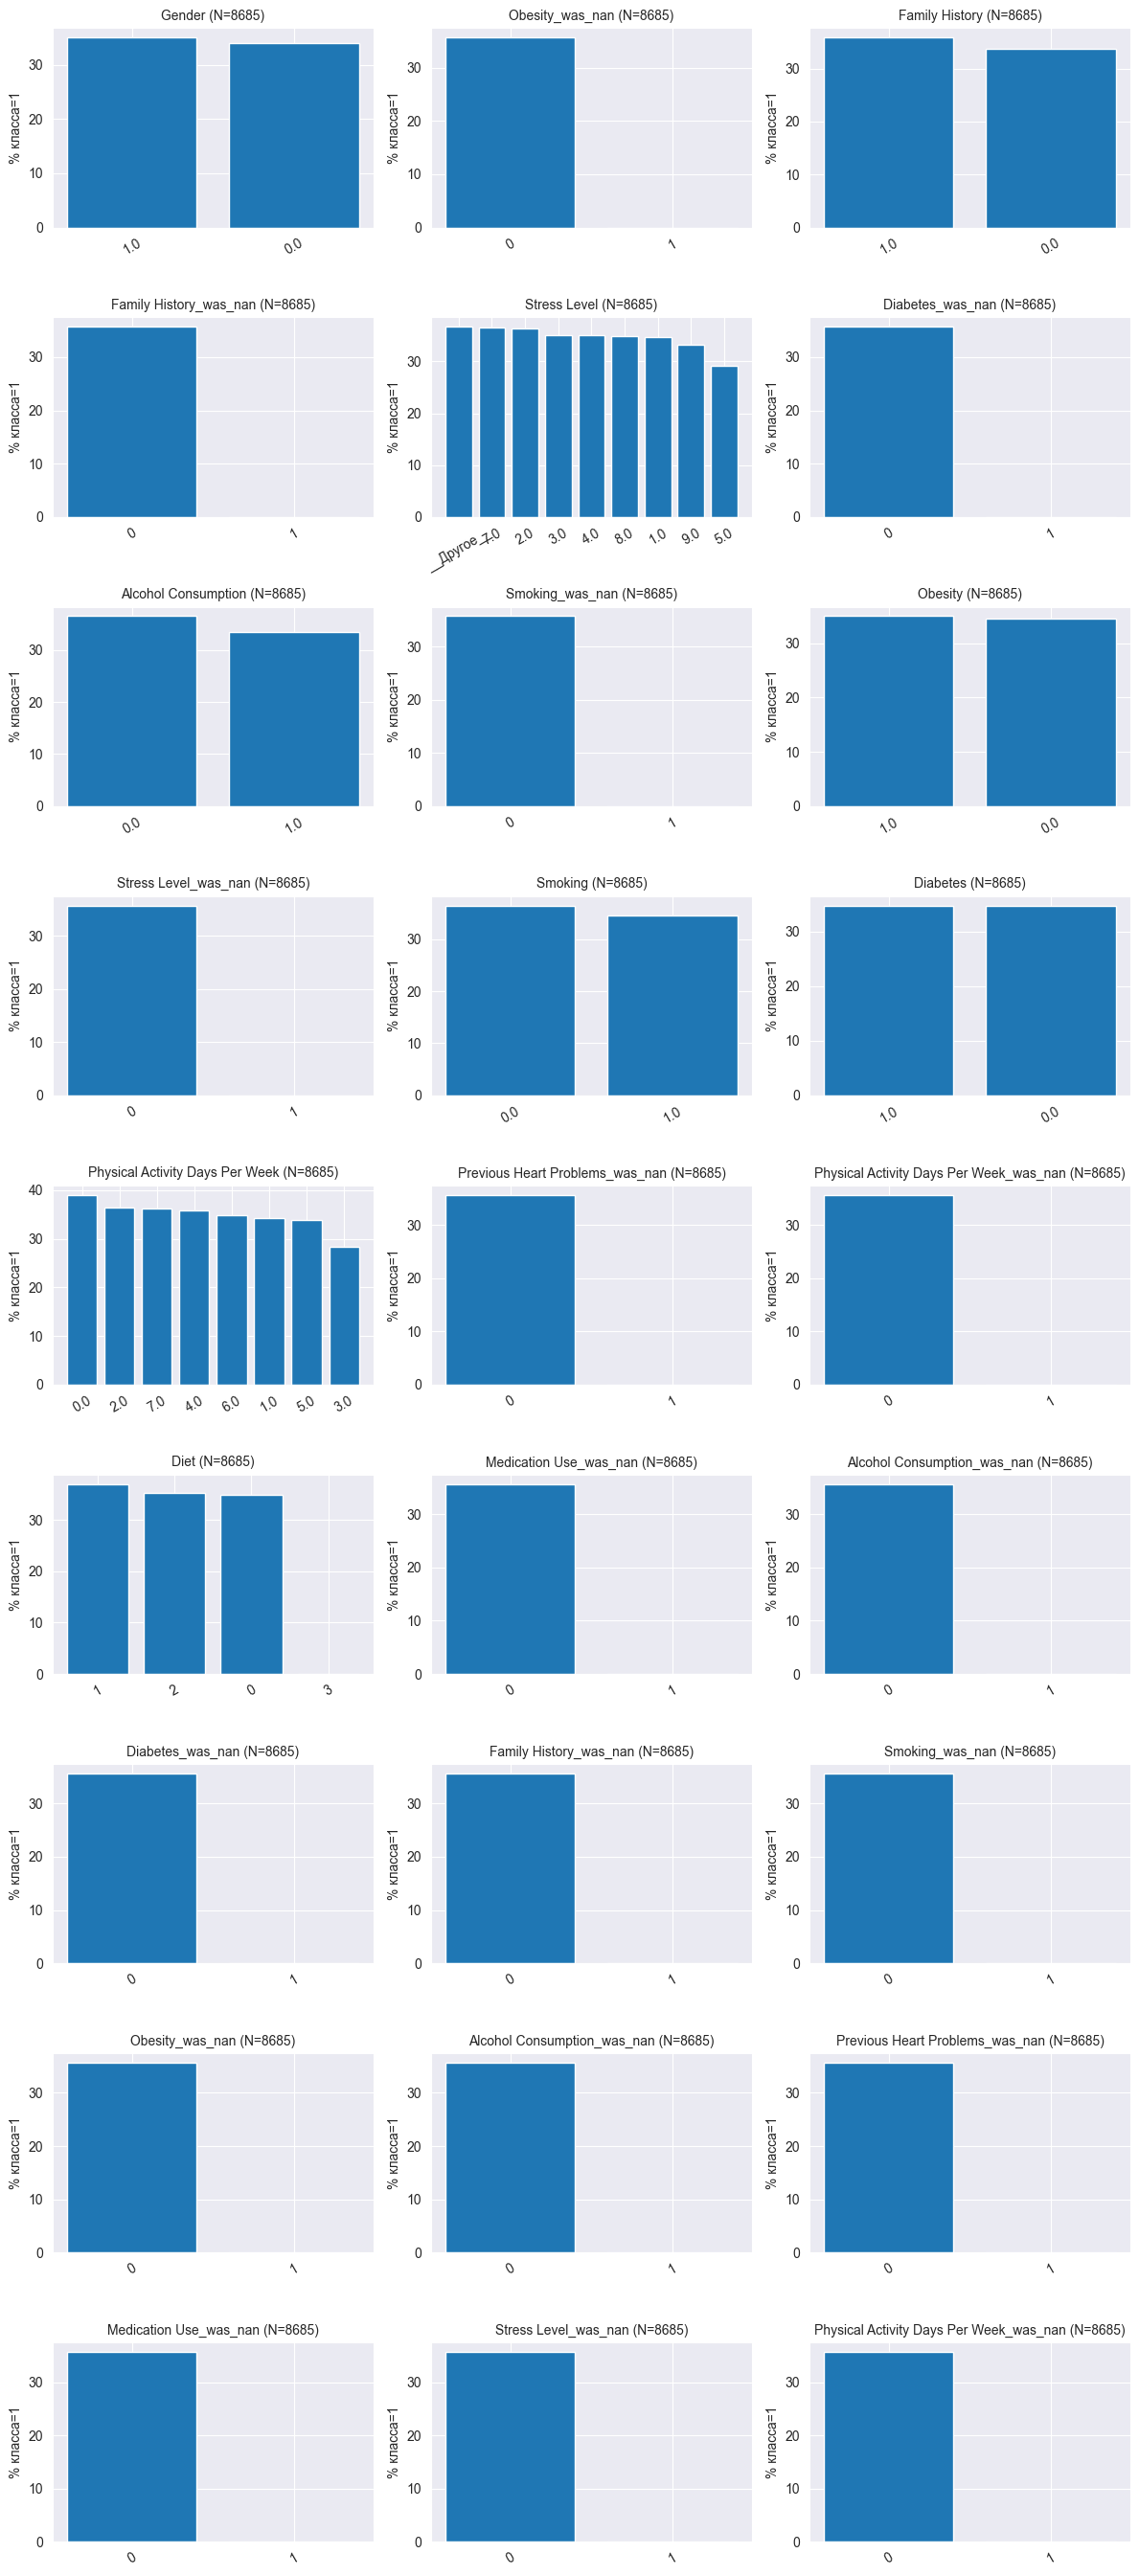

### TRAIN · графики: boxplot непрерывных vs таргет

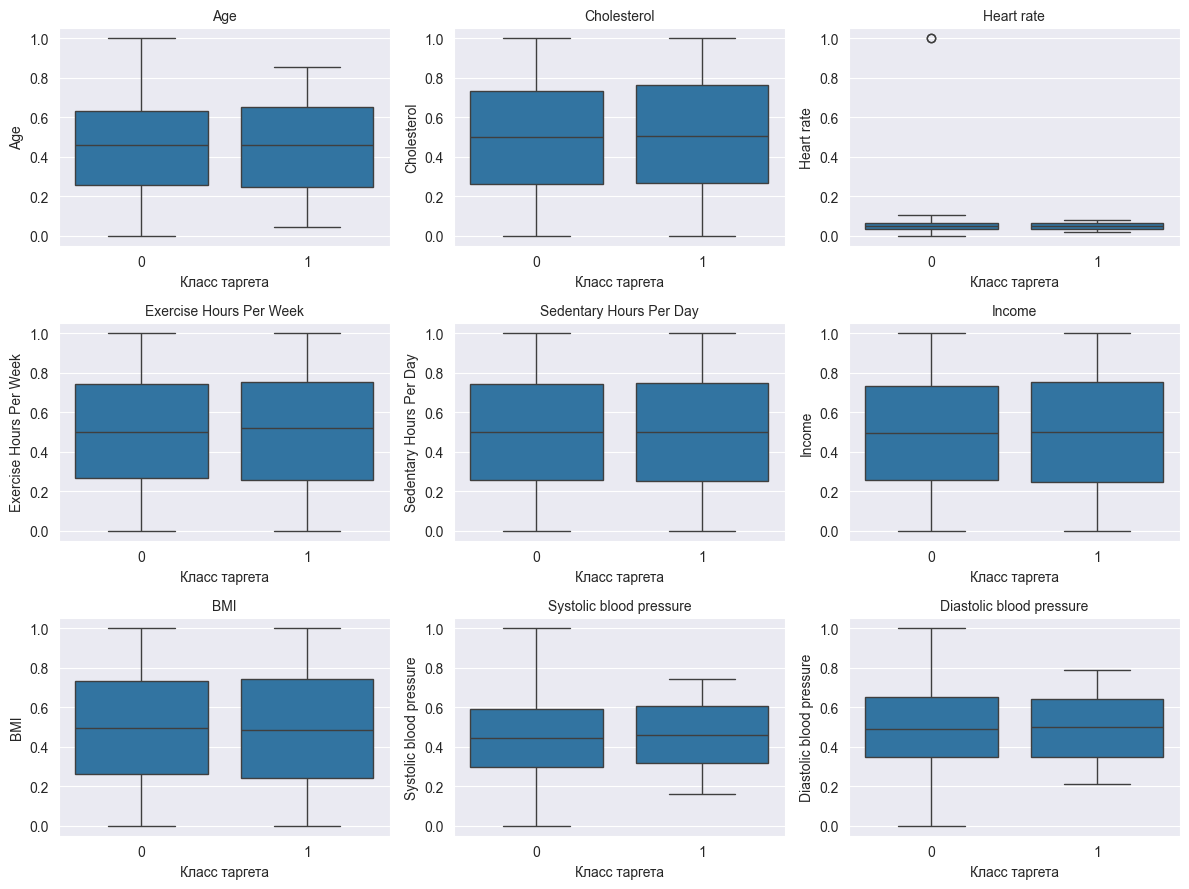

---

### TEST · состав фичей (тип / уникальные / пропуски)

,тип,уникальные,пропуски
Age,float64,73,0
Alcohol Consumption,float64,2,0
Alcohol Consumption_was_nan,int64,2,0
BMI,float64,924,0
Blood sugar,float64,124,0
CK-MB,float64,183,0
Cholesterol,float64,266,0
Diabetes,float64,2,0
Diabetes_was_nan,int64,2,0
Diastolic blood pressure,float64,54,0


### TEST · пропуски (шт)

Family History                     31
Diabetes                           31
Alcohol Consumption                31
Obesity                            31
Smoking                            31
Previous Heart Problems            31
Physical Activity Days Per Week    31
Stress Level                       31
Medication Use                     31
dtype: int64

### TEST · пики (автопоиск)

,feature,bin_center,bin_left,bin_right,count,pct_in_bin
0,Income,0.459638,0.418157,0.501118,124,12.84


### TEST · выбросы (IQR)

,Признак,N,% выбросов,Нижняя граница,Верхняя граница,Мин. выброс,Макс. выброс
1,Blood sugar,966,24.84,0.227018,0.227018,0.029644,0.750988
2,CK-MB,966,24.84,0.048229,0.048229,0.000000,1.000000
3,Troponin,966,24.84,0.036512,0.036512,0.000194,0.970871
0,Heart rate,966,0.10,-0.007333,0.109991,1.000000,1.000000


In [36]:
# Запуск EDA


# 1) Запуск
eda = EDAHelper(
    target="Heart Attack Risk (Binary)", id_col="id",
    technical_cols=("Unnamed: 0",),
    leakage_cols=("Troponin","CK-MB","Previous Heart Problems","Medication Use"),
    proxy_cols=("Triglycerides","Blood sugar"),
    ordinal_cols_guess=("Stress Level","Physical Activity Days Per Week","Diet"),
    gender_col="Gender",
)
res = eda.fit_report(train_df, test_df)

# 2) Хелперы
hdr = lambda t: display(Markdown(f"### {t}"))
sep = lambda: display(Markdown("---"))
def feature_summary(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "тип": df.dtypes,
        "уникальные": df.nunique(dropna=True),
        "пропуски": df.isna().sum()
    }).sort_index()

tr = res["train_clean"]
ts = res["test_clean"]

# 3) Cаммари (общее)
display(Markdown("## Итоговый отчёт EDA "))
display(Markdown(res["reports"]["summary_md"]))

# 4) Проверка ID между выборками
hdr("Проверка ID (train ↔ test)")
id_chk = res["reports"]["id_check"]
display(Markdown(
    f"- Уникальные ID в train: **{id_chk.get('train_ids','—')}**, дубликаты: **{id_chk.get('dup_train','—')}**  \n"
    f"- Уникальные ID в test: **{id_chk.get('test_ids','—')}**, дубликаты: **{id_chk.get('dup_test','—')}**  \n"
    f"- Пересечение train∩test: **{id_chk.get('intersection','—')}**"
    + (f" (примеры: {', '.join(map(str, id_chk.get('intersection_sample', [])))})"
       if id_chk.get('intersection', 0) > 0 else "")
))

# ------------------------------ TRAIN ------------------------------
sep(); hdr("TRAIN · состав фичей (тип / уникальные / пропуски)")
display(feature_summary(tr))

hdr("TRAIN · матрица корреляций (Spearman)")
eda.corr_heatmap(tr, method="spearman", annot=True, cbar=True, show=True)

hdr("TRAIN · пропуски (шт)")
display(res["reports"]["missing_train"][res["reports"]["missing_train"] > 0])

hdr("TRAIN · пики (автопоиск)")
display(res["reports"]["peaks"].head(30) if res["reports"]["peaks"] is not None else pd.DataFrame())

hdr("TRAIN · выбросы (IQR)")
display(res["reports"]["outliers"].head(30) if res["reports"]["outliers"] is not None else pd.DataFrame())

hdr("TRAIN · таргет: распределение классов")
display(res["reports"]["target_distribution"])

tbc = res["reports"].get("target_by_cats")
if tbc is not None and not tbc.empty:
    hdr("TRAIN · таргет по категориям и флагам *_was_nan")
    display(tbc.head(40))

tbq = res["reports"].get("target_by_quantiles")
if tbq is not None and not tbq.empty:
    hdr("TRAIN · таргет по квантилям непрерывных (децили)")
    display(tbq.head(40))

hdr("TRAIN · графики: доля класса=1 по категориям")
eda.plot_target_rate_by_cats(tr)

hdr("TRAIN · графики: boxplot непрерывных vs таргет")
eda.plot_box_by_target(tr)

# ------------------------------ TEST ------------------------------
sep(); hdr("TEST · состав фичей (тип / уникальные / пропуски)")
display(feature_summary(ts))

hdr("TEST · пропуски (шт)")
display(res["reports"]["missing_test"][res["reports"]["missing_test"] > 0])

hdr("TEST · пики (автопоиск)")
peaks_test = eda.detect_peaks_auto(ts, bins="fd", min_share=0.02, prominence=1.5, top_k=3)
display(peaks_test.head(30))

hdr("TEST · выбросы (IQR)")
outs_test = eda.detect_outliers(ts, method="iqr", iqr_factor=1.5)
display(outs_test.head(30))


# Отчёт по EDA
**Цель:** по данным о пациентах оценивать вероятность инфаркта (да/нет).

---

## 1) Что за данные
- **Train (обучение):** 8 685 записей, 28 столбцов, есть целевой признак *Heart Attack Risk (Binary)*.
- **Test (прогноз):** 966 записей, 27 столбцов, целевого признака нет (его надо предсказывать).
- В таблицах есть показатели возраста, давления, холестерина, сахара и др., а также флаги вроде «Курит/Не курит».

**Проверка ID:** дубликатов нет, пересечений ID между train и test нет - наборы корректны.

---

## 2) Что мы сделали с данными
1. **Убрали служебный столбец** `Unnamed: 0` (он был просто индексом из файла).
2. **Нормализовали поле пола** `Gender` → 0/1 (чтобы не было смешения форматов Male/Female и 0/1).
3. **Разобрались с пропусками.**
   - В ~9 полях (например, *Smoking, Diabetes, Stress Level*) были пропуски.
   - Мы их заполнили простыми и понятными правилами (для чисел — медиана, для 0/1 — наиболее частое значение).
   - Чтобы не терять информацию о самом факте пропуска, **добавили флажок** `*_was_nan` (=1, если в исходных данных тут была пустота).
4. **Проверили необычные значения.**
   - Нашли «выбросы» у лабораторных показателей (*Troponin, CK-MB, Blood sugar*) — это ожидаемо, т.к. там часто много нулей и редкие высокие значения. Так же есть выбросы около 0,5 надо будет учесть при обучении модели
5. **Посмотрели связь признаков с целевым.**
   - Построили теплокарту корреляций (направление и сила связи). Линейных сильных связей почти нет → потребуется модель, которая учитывает **нелинейности**.
   - Показали, как меняется доля «инфаркт=1» по категориям и по диапазонам числовых показателей (боксплоты и маленькие столбчатые графики).

---

## 3) Ключевые наблюдения
- **Баланс классов в train:** 0 — **65.3%**, 1 — **34.7%**. Критического перекоса нет.
- **Пропуски:** ~3% записей по 9 полям; в test картина похожая — наборы сопоставимы.
- **Флажки пропусков `*_was_nan`:** в train все записи с этими флажками имеют **0%** случаев инфаркта. Это делает флаг мощной «подсказкой», но **в реальных данных** причина пропусков может быть другой — эффект может пропасть.
- **Спорные признаки (риск утечки):**
  - `Troponin`, `CK-MB`, `Previous Heart Problems`, `Medication Use` — вероятные признаки уже случившегося события/лечения - скорее всего **не использовать** в прогностической модели.
  - Возможные **прокси**: `Triglycerides`, `Blood sugar` — оставим для экспериментов «с ними/без них».
- **Поведение понятных факторов:**
  - **Физическая активность (дни/нед):** 0 дней ≈ **39%** риска, 3 дня ≈ **28%** — здравый, ожидаемый эффект.
  - **Возраст, давление, холестерин, BMI:** связь **нелинейная** — на краях диапазонов риск выше.
  - Отдельные бинарные факторы образа жизни (курение, ожирение и т.п.) по одиночке дают небольшой разрыв; полезнее в комбинации.
- **Мультиколлинеарность (VIF):** `Smoking = 16.35` (**сильная**, >10), далее `Blood sugar = 8.76`, `Diastolic BP = 8.39`, `Systolic BP = 7.35`, `Age = 5.89`, `Heart rate = 5.32` (**умеренная**, 5–10).
  Это означает, что часть признаков линейно объясняют друг друга; коэффициенты линейной/логистической регрессии будут нестабильны и малоинтерпретируемы. **Вывод:** в качестве основных моделей используем деревья/бустинги (база — **CatBoost**; для сравнения — **LightGBM/XGBoost**; бэйзлайн — **Random Forest**). Для дисбаланса классов применяем `class_weights/scale_pos_weight`, метрики — **ROC-AUC** и **PR-AUC**. Признаки-утечки исключаем из обучения.
- **Метрики и интерпретация**
- Основные метрики: ROC-AUC, PR-AUC, **F score**; при смещённом приоритете на выявление случаев допускаем **F2**.
- Порог классификации подбираем по валидации под максимум F1 (или под заданную Recall/Precision).
- Для объяснимости используем **SHAP**:
  - глобально — топ-фичи и их вклад в модель;
  - локально — почему у конкретного пациента риск высокий/низкий.

---

## 4) Что это значит для модели
- Простая «прямая» модель (как линейная регрессия) будет слабой — **мало прямых линейных связей**.
- Подойдут модели, которые видят **нелинейность и взаимодействия признаков**: CatBoost / LightGBM / XGBoost.
- **Утечки скорее всего исключаем**: `Troponin`, `CK-MB`, `Previous Heart Problems`, `Medication Use` — проверяем отдельно: *с ними* и *без них*.
- **Прокси-признаки** (`Triglycerides`, `Blood sugar`) — проверяем отдельно: *с ними* и *без них*.
- **Флаги пропусков `*_was_nan`**: — проверяем отдельно: *с ними* и *без них*, возможно удалим, если не дадут значимости

---

## 5) План действий
1. Провести фича инжиниринг, добавив признаки, сформированные из существующих признаков.
2. Обучить базовую модель на **безопасных признаках** (без утечек; прокси выключены).
2. Повторить с включёнными **прокси** (`Triglycerides`, `Blood sugar`) — сравнить качество.
3. Ещё раз повторить оба шага, но **без флажков `*_was_nan`**, и сравнить все варианты.
4. Выбрать стабильную конфигурацию (по кросс-валидации), настроить рабочий порог (баланс «поймать больше случаев» vs «поменьше ложных тревог»), калибровать вероятности.
5. Зафиксировать конвейер подготовки данных и модель, предсказать **test** (ID сохраняем, чтобы понять «кому что предсказали»).

> **Итог:** данные годятся для прогноза, но «чудо-признака» нет — сигнал распределён и нелинеен.
> Мы исключим явные утечки, аккуратно обойдёмся с пропусками и проверим несколько прозрачных конфигураций, чтобы выбрать ту, которая и точная, и устойчивая.



# План обучения моделей

1) **Данные (сырые, без утечек)**
- Загружаем *исходные* `heart_train.csv` (ничего не заполняем заранее).
- Удаляем техн. столбцы (`Unnamed: 0` и пр.), `id` сохраняем отдельно.
- Нормализуем `Gender` → {0,1} детерминированным маппингом.

2) **Сплит и контроль утечек**
- Делим `heart_train.csv` → train/valid (Stratified, фикс. `random_state`).
- Любые преобразования делаем **только внутри `Pipeline`** → `.fit()` учится на **train**, `.transform()` на valid/test.
  - `SimpleImputer(strategy="median", add_indicator=True|False)`

3) **Наборы признаков (4 сценария)**
- **S0:** всё (без `id` и технич.).
- **S1:** S0 **минус предполагаемые утечки**: `Troponin`, `CK-MB`, `Previous Heart Problems`, `Medication Use`.
- **S2:** S1 **минус прокси**: `Triglycerides`, `Blood sugar`.
- **S3:** S2 **минус** индикаторы пропусков `*_was_nan`.

4) **Модели**
- Основные: **CatBoostClassifier**, **HistGradientBoosting** (или LightGBM/XGBoost по желанию).

5) **Метрики и порог**
- Оптимизируем **F2** (приоритет recall). Дополнительно: **F1**, **ROC-AUC**, **PR-AUC**.
- Порог класса подбираем на валидации по максимуму **F2** (по PR-кривой). Логируем `FP`, `FN`, порог.

6) **Валидация**
- Быстрый отбор: hold-out (20%).
- Итог: **Stratified KFold (5)** → средние/медианные значения метрик и порога.

7) **Подбор гиперпараметров**
- CatBoost: `depth 4–8`, `learning_rate 0.02–0.1`, `n_estimators` с early stopping, `auto_class_weights="Balanced"`.
- HGB: `max_iter` с early stopping, `learning_rate 0.05–0.2`, `class_weight="balanced"`.

8) **Сравнение сценариев**
- Для каждого из S0–S3 прогоняем те же модели и логируем **F2/F1/AUC**, `FP/FN`, время.

9) **Финальная модель**
- Выбираем (сценарий, модель, гиперпараметры, порог).
- Дообучаем **на всём train** тем же `Pipeline`, фиксируем найденный порог.

10) **Инференс на `heart_test.csv`**
- Применяем сохранённый `Pipeline` (`transform`/`predict_proba`) и **фиксированный порог F2**.
- Сохраняем `id, proba, label` (CSV) + артефакты: сериализованный Pipeline, конфиг, метрики, seed.


In [37]:
# ============================ ГЛОБАЛЬНЫЕ НАСТРОЙКИ ============================
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# --- Данные ---
DATA_DIR = Path.cwd().parent / "data"
PATH_TRAIN = DATA_DIR / "heart_train.csv"
train_raw = pd.read_csv(PATH_TRAIN)

# --- Константы/настройки ---
TARGET = "Heart Attack Risk (Binary)"
IDCOL = "id"
TECH = ("Unnamed: 0",)
LEAK = ("Troponin", "CK-MB", "Previous Heart Problems", "Medication Use")   # утечки
PROXY = ("Triglycerides", "Blood sugar")                                     # прокси
GENDER_COL = "Gender"
GENDER_MAP = {"male": 1, "m": 1, "female": 0, "f": 0, "Male": 1, "Female": 0}

# Оптимизация порога
MIN_RECALL = 0.95
BETA_F2 = 2.0

# Бутстрап
BOOT_B = 500
REOPTIMIZE_IN_BOOT = False  # если True — в каждом бутстрапе подбираем порог заново

# SHAP
SHAP_SAMPLE_PER_FOLD = 1000  # 0 → не считать SHAP в CV
TOPK_SHAP = 20

# Калибровка вероятностей
USE_CALIBRATION = True                # isotonic внутри фолда
ALLOW_SHAP_THROUGH_CALIBRATOR = False # не считаем SHAP через калибратор

# Детект «пика 0.5» и его маскирование при расчёте квантилей
DETECT_SPIKES = True
SPIKE_BAND_EPS = 0.02   # ширина центральной полосы вокруг 0.5
ADD_HALF_FLAGS = False  # добавить флаги *_is_050 как признаки

# ============================ ФИЧЕРИНГ ============================
class ClinicalFeatureBuilder(BaseEstimator, TransformerMixin):
    """
    Фичеринг без утечек.
      - fe_mode='raw'       -> только сырые числовые признаки (+пол)
      - fe_mode='quantile'  -> квантильные клин-флаги/MetSyn (устойчиво к неизвестной нормализации)
    Квантили оцениваются на TRAIN-фолде (fit), применяются к VAL (transform).
    Дополнительно: авто-детект «пика 0.5» и маскирование центральной полосы при расчёте квантилей.
    """
    def __init__(self,
                 include_leaks: bool,
                 include_proxies: bool,
                 fe_mode: str = "quantile",
                 quantile: float = 0.9,
                 detect_spikes: bool = DETECT_SPIKES,
                 band_eps: float = SPIKE_BAND_EPS,
                 add_half_flags: bool = ADD_HALF_FLAGS):
        self.include_leaks = bool(include_leaks)
        self.include_proxies = bool(include_proxies)
        self.fe_mode = fe_mode
        self.quantile = float(quantile)
        self.detect_spikes = bool(detect_spikes)
        self.band_eps = float(band_eps)
        self.add_half_flags = bool(add_half_flags)

        self.q_: Dict[str, float] = {}
        self.derived_features_: List[str] = []
        self.out_columns_: Optional[List[str]] = None
        self.spiky_cols_: List[str] = []

    def _col_or_nan(self, X: pd.DataFrame, name: str) -> pd.Series:
        return X[name] if name in X.columns else pd.Series(np.nan, index=X.index)

    def _is_spiky(self, x: pd.Series, bins: int = 20, ratio: float = 1.3) -> bool:
        v = pd.to_numeric(x, errors="coerce").dropna().values
        if v.size == 0: return False
        hist, edges = np.histogram(v, bins=bins, range=(0.0, 1.0))
        mid = np.searchsorted(edges, 0.5, side='right') - 1
        med = np.median(hist) if hist.size else 0
        return (med > 0) and (mid >= 0) and (mid < len(hist)) and (hist[mid] / med >= ratio)

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()
        # убрать тех. столбцы
        unnamed = [c for c in X.columns if str(c).lower().startswith("unnamed")]
        X.drop(columns=[c for c in TECH if c in X.columns] + unnamed, errors="ignore", inplace=True)
        # пол → {0,1}
        if GENDER_COL in X.columns:
            s = X[GENDER_COL].astype(str).str.strip().map(GENDER_MAP)
            X[GENDER_COL] = pd.to_numeric(s, errors="coerce")
        # квантили и детект «спайков»
        if self.fe_mode == "quantile":
            # спайки
            if self.detect_spikes:
                for c in ["Triglycerides", "Exercise Hours Per Week", "BMI",
                          "Diastolic blood pressure", "Cholesterol", "Blood sugar", "Income"]:
                    if c in X.columns and self._is_spiky(X[c]):
                        self.spiky_cols_.append(c)
            # квантили с маскированием центральной полосы для «спайковых»
            for col in ["BMI", "Systolic blood pressure", "Diastolic blood pressure",
                        "Cholesterol", "Triglycerides", "Blood sugar"]:
                if col in X.columns:
                    x = pd.to_numeric(X[col], errors="coerce")
                    if col in self.spiky_cols_:
                        x = x[~((x - 0.5).abs() <= self.band_eps)]
                    self.q_[col] = float(x.quantile(self.quantile))
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        unnamed = [c for c in X.columns if str(c).lower().startswith("unnamed")]
        X.drop(columns=[c for c in TECH if c in X.columns] + unnamed, errors="ignore", inplace=True)
        if GENDER_COL in X.columns:
            s = X[GENDER_COL].astype(str).str.strip().map(GENDER_MAP)
            X[GENDER_COL] = pd.to_numeric(s, errors="coerce")

        drop_cols = [c for c in (TARGET, IDCOL) if c in X.columns]
        self.derived_features_ = []

        if self.fe_mode == "raw":
            if not self.include_leaks:   drop_cols += [c for c in LEAK if c in X.columns]
            if not self.include_proxies: drop_cols += [c for c in PROXY if c in X.columns]
            X.drop(columns=drop_cols, errors="ignore", inplace=True)
            X = X.select_dtypes(include=[np.number])

        elif self.fe_mode == "quantile":
            bmi = self._col_or_nan(X, "BMI")
            ob_flag = (bmi >= self.q_.get("BMI", np.inf)) | (self._col_or_nan(X, "Obesity") == 1)

            sbp = self._col_or_nan(X, "Systolic blood pressure")
            dbp = self._col_or_nan(X, "Diastolic blood pressure")
            bp_flag = (sbp >= self.q_.get("Systolic blood pressure", np.inf)) | \
                      (dbp >= self.q_.get("Diastolic blood pressure", np.inf))

            chol = self._col_or_nan(X, "Cholesterol")
            high_chol_flag = (chol >= self.q_.get("Cholesterol", np.inf))

            trig = self._col_or_nan(X, "Triglycerides")
            bs = self._col_or_nan(X, "Blood sugar")
            trig_flag = (trig >= self.q_.get("Triglycerides", np.inf)) if self.include_proxies else pd.Series(False, index=X.index)
            glucose_flag = (bs >= self.q_.get("Blood sugar", np.inf)) if self.include_proxies else pd.Series(False, index=X.index)

            metsyn_score = (
                ob_flag.fillna(False).astype(int)
                + bp_flag.fillna(False).astype(int)
                + trig_flag.fillna(False).astype(int)
                + glucose_flag.fillna(False).astype(int)
            ).astype(float)
            metsyn_den = 2 + 2 * int(self.include_proxies)
            X["MetSyn_score"] = metsyn_score
            X["MetSyn_score_norm"] = X["MetSyn_score"] / metsyn_den
            self.derived_features_ += ["MetSyn_score", "MetSyn_score_norm"]

            X["BMI_category"] = np.where(bmi < bmi.quantile(0.25), 0,
                                  np.where(bmi < bmi.quantile(0.50), 1,
                                  np.where(bmi < bmi.quantile(0.75), 2, 3))).astype(float)
            self.derived_features_ += ["BMI_category"]

            X["HTN_flag"] = bp_flag.astype(int);             self.derived_features_ += ["HTN_flag"]
            X["HighChol_flag"] = high_chol_flag.astype(int); self.derived_features_ += ["HighChol_flag"]

            if self.include_proxies:
                diabetes_flag = self._col_or_nan(X, "Diabetes")
                X["Prediabetes_flag"] = ((glucose_flag.astype(bool)) & (diabetes_flag == 0)).astype(int)
                self.derived_features_ += ["Prediabetes_flag"]
                X["MetSyn_flag"] = (X["MetSyn_score"] >= 3).astype(int)
                self.derived_features_ += ["MetSyn_flag"]

            # флаги «центр 0.5»
            if self.add_half_flags:
                for col in self.spiky_cols_:
                    if col in X.columns:
                        X[f"{col}_is_050"] = ((pd.to_numeric(X[col], errors="coerce") - 0.5).abs() <= self.band_eps).astype(int)
                        self.derived_features_ += [f"{col}_is_050"]

            if self.include_leaks and "Troponin" in X.columns:
                X["Troponin_flag"] = (X["Troponin"] > X["Troponin"].median()).astype(int)
                self.derived_features_ += ["Troponin_flag"]
            if self.include_leaks and "CK-MB" in X.columns:
                X["CKMB_flag"] = (X["CK-MB"] > X["CK-MB"].median()).astype(int)
                self.derived_features_ += ["CKMB_flag"]

            if not self.include_leaks:   drop_cols += [c for c in LEAK if c in X.columns]
            if not self.include_proxies: drop_cols += [c for c in PROXY if c in X.columns]
            X.drop(columns=drop_cols, errors="ignore", inplace=True)
            X = X.select_dtypes(include=[np.number])
        else:
            raise ValueError(f"Unknown fe_mode={self.fe_mode}")

        self.out_columns_ = list(X.columns)
        return X

# ============================ МОДЕЛИ ============================
def make_model(name: str):
    if name == "catboost":
        return CatBoostClassifier(
            depth=6, learning_rate=0.05, n_estimators=1000,
            loss_function="Logloss", eval_metric="AUC", auto_class_weights="Balanced",
            verbose=0, random_state=RANDOM_SEED,
        )
    if name == "hgb":
        return HistGradientBoostingClassifier(
            max_depth=None, learning_rate=0.1, max_iter=400,
            random_state=RANDOM_SEED, class_weight="balanced",
        )
    raise ValueError("unknown model")

def make_pipeline(include_leaks: bool,
                  include_proxies: bool,
                  fe_mode: str,
                  quantile: float,
                  model_name: str) -> Pipeline:
    # трансформер фичей
    builder = ClinicalFeatureBuilder(
        include_leaks=include_leaks,
        include_proxies=include_proxies,
        fe_mode=fe_mode,
        quantile=quantile,
        detect_spikes=DETECT_SPIKES,
        band_eps=SPIKE_BAND_EPS,
        add_half_flags=ADD_HALF_FLAGS
    )

    base = make_model(model_name)

    # калибруем только HGB (CatBoost оставляем как есть)
    CALIBRATE_MODELS = {"hgb"}

    if USE_CALIBRATION and (model_name in CALIBRATE_MODELS):
        # совместимость с разными версиями sklearn
        try:
            clf = CalibratedClassifierCV(estimator=base, method="isotonic", cv=3)
        except TypeError:
            clf = CalibratedClassifierCV(base_estimator=base, method="isotonic", cv=3)
    else:
        clf = base

    return Pipeline([
        ("feat", builder),
        ("imp", SimpleImputer(strategy="median")),
        ("clf", clf),
    ])

# ============================ ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ============================
def choose_threshold(y_true: np.ndarray, p: np.ndarray, min_recall: float, beta: float = 2.0) -> float:
    prec, rec, thr = precision_recall_curve(y_true, p)
    prec_, rec_, thr_ = prec[1:], rec[1:], thr
    if min_recall and min_recall > 0:
        mask = rec_ >= min_recall
        if mask.any():
            f2_curve = (1 + beta**2) * prec_[mask] * rec_[mask] / (beta**2 * prec_[mask] + rec_[mask] + 1e-12)
            return float(thr_[mask][np.argmax(f2_curve)])
        else:
            f2_curve = (1 + beta**2) * prec_ * rec_ / (beta**2 * prec_ + rec_ + 1e-12)
            return float(thr_[np.argmax(f2_curve)]) if len(thr_) else 0.5
    else:
        f2_curve = (1 + beta**2) * prec_ * rec_ / (beta**2 * prec_ + rec_ + 1e-12)
        return float(thr_[np.argmax(f2_curve)]) if len(thr_) else 0.5

def choose_threshold_safe(y: np.ndarray, p: np.ndarray,
                          beta: float = 2.0, min_recall: float = 0.95,
                          grid: int = 400, B: int = 500, rng: Optional[np.random.Generator] = None) -> float:
    """Подбор порога с гарантией: 5-й перцентиль бутстрапа по recall ≥ min_recall."""
    rng = np.random.default_rng(RANDOM_SEED) if rng is None else rng
    thr_grid = np.linspace(0.0, 1.0, grid, dtype=float)

    def boot_recall_at_thr(thr: float) -> float:
        vals = []
        for _ in range(B):
            idx = stratified_bootstrap_indices(y, rng)
            yb, pb = y[idx], p[idx]
            yhat = (pb >= thr).astype(int)
            vals.append(recall_score(yb, yhat, zero_division=0))
        return float(np.percentile(vals, 5))

    candidates = []
    for thr in thr_grid:
        r5 = boot_recall_at_thr(thr)
        if r5 >= min_recall:
            m = metrics_from_predictions(y, p, thr)
            candidates.append((m["f2_val"], thr))
    if candidates:
        return max(candidates)[1]
    return choose_threshold(y, p, min_recall, beta)

def metrics_from_predictions(y_true: np.ndarray, p: np.ndarray, thr: float) -> Dict[str, Any]:
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    return {
        "roc_auc": roc_auc_score(y_true, p),
        "pr_auc": average_precision_score(y_true, p),
        "f1_val": f1_score(y_true, yhat),
        "f2_val": fbeta_score(y_true, yhat, beta=2),
        "precision_val": precision_score(y_true, yhat, zero_division=0),
        "recall_val": recall_score(y_true, yhat, zero_division=0),
        "specificity": tn / (tn + fp) if (tn + fp) else np.nan,
        "npv": tn / (tn + fn) if (tn + fn) else np.nan,
        "brier": brier_score_loss(y_true, p),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "n": int(len(y_true))
    }

def stratified_bootstrap_indices(y: np.ndarray, rng: np.random.Generator, size: Optional[int] = None) -> np.ndarray:
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]; idx_neg = np.where(y == 0)[0]
    n_pos, n_neg = len(idx_pos), len(idx_neg)
    if size is None:
        size_pos, size_neg = n_pos, n_neg
    else:
        frac_pos = n_pos / (n_pos + n_neg + 1e-12)
        size_pos = int(round(size * frac_pos)); size_neg = size - size_pos
    boot_pos = rng.integers(0, n_pos, size_pos)
    boot_neg = rng.integers(0, n_neg, size_neg)
    return np.concatenate([idx_pos[boot_pos], idx_neg[boot_neg]])

def bootstrap_metrics_on_oof(y: np.ndarray, p: np.ndarray, thr_fixed: float,
                             B: int = 1000, reoptimize_threshold: bool = False,
                             min_recall: float = MIN_RECALL, beta: float = BETA_F2,
                             random_state: int = RANDOM_SEED) -> pd.DataFrame:
    y = np.asarray(y); p = np.asarray(p)
    rng = np.random.default_rng(random_state)
    rows = []
    for _ in range(B):
        idx = stratified_bootstrap_indices(y, rng)
        y_b, p_b = y[idx], p[idx]
        thr = choose_threshold(y_b, p_b, min_recall, beta) if reoptimize_threshold else thr_fixed
        m = metrics_from_predictions(y_b, p_b, thr)
        m["thr_used"] = thr
        rows.append(m)
    return pd.DataFrame(rows)

def summarize_ci(df: pd.DataFrame, cols: List[str], lower: float = 2.5, upper: float = 97.5) -> pd.DataFrame:
    out = {}
    for c in cols:
        out[f"{c}_med"] = df[c].median()
        out[f"{c}_lo"]  = np.percentile(df[c], lower)
        out[f"{c}_hi"]  = np.percentile(df[c], upper)
    return pd.DataFrame([out])

# ============================ CV + OOF + SHAP ============================
def compute_fold_shap_abs(pipe: Pipeline, builder: ClinicalFeatureBuilder,
                          X_val_df: pd.DataFrame, y_val: np.ndarray,
                          model_name: str, max_samples: int = 1000,
                          rng: np.random.Generator = rng) -> Tuple[np.ndarray, List[str]]:
    """Возвращает |SHAP| матрицу (n_samples, n_features) и список имён; безопасно отключается."""
    # матрица после трансформера и импьютера
    X_feat = builder.transform(X_val_df)
    X_val = pipe.named_steps["imp"].transform(X_feat)
    feature_names = list(X_feat.columns)

    n = X_val.shape[0]
    if max_samples is None or max_samples <= 0 or n == 0:
        return np.empty((0, len(feature_names))), feature_names

    clf = pipe.named_steps["clf"]
    # если есть калибратор и мы запретили SHAP через него — выходим
    if isinstance(clf, CalibratedClassifierCV) and not ALLOW_SHAP_THROUGH_CALIBRATOR:
        return np.empty((0, len(feature_names))), feature_names

    take = min(max_samples, n)
    idx = rng.choice(n, size=take, replace=False)
    X_s = X_val[idx]
    y_s = y_val[idx] if y_val is not None else None

    # CatBoost — нативный SHAP
    if model_name == "catboost":
        pool = Pool(X_s, label=y_s)
        shap_vals = clf.get_feature_importance(pool, type='ShapValues')
        shap_vals = np.array(shap_vals)[:, :-1]  # последний — base value
        return np.abs(shap_vals), feature_names

    # HGB — shap / fallback
    if model_name == "hgb" and SHAP_AVAILABLE:
        try:
            explainer = shap.Explainer(clf)
            sv = explainer(X_s)
            vals = sv.values[1] if isinstance(sv.values, list) else sv.values
            return np.abs(np.array(vals)), feature_names
        except Exception:
            pass

    # Бэкап: permutation importance
    try:
        pi = permutation_importance(clf, X_s, y_s, n_repeats=10, random_state=RANDOM_SEED)
        imp = np.abs(pi.importances_mean)
        return np.tile(imp, (X_s.shape[0], 1)), feature_names
    except Exception:
        return np.zeros((0, len(feature_names))), feature_names

def run_cv_oof_with_shap(model_name: str, scenario_name: str,
                         include_leaks: bool, include_proxies: bool,
                         fe_mode: str, df_raw: pd.DataFrame,
                         n_splits: int = 5, quantile: float = 0.9,
                         shap_sample_per_fold: int = SHAP_SAMPLE_PER_FOLD) -> Dict[str, Any]:
    """5-fold CV: OOF-предсказания, thr_opt, SHAP (подвыборка)."""
    assert TARGET in df_raw.columns, f"В данных нет целевой колонки {TARGET!r}"
    y_all = df_raw[TARGET].values

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    p_all, y_val_all = [], []
    shap_blocks = []
    n_features_seen: List[int] = []
    derived_seen: List[str] = []
    spiky_seen: List[str] = []
    last_feat_names: List[str] = []
    t0 = time.time()

    for tr_idx, va_idx in skf.split(df_raw, y_all):
        df_tr = df_raw.iloc[tr_idx].copy()
        df_va = df_raw.iloc[va_idx].copy()
        y_va = df_va[TARGET].values

        pipe = make_pipeline(include_leaks, include_proxies, fe_mode, quantile, model_name)
        pipe.fit(df_tr, df_tr[TARGET].values)

        p_va = pipe.predict_proba(df_va)[:, 1]
        p_all.append(p_va); y_val_all.append(y_va)

        # аудит
        builder: ClinicalFeatureBuilder = pipe.named_steps["feat"]
        try:
            n_features_seen.append(int(pipe.named_steps["imp"].n_features_in_))
        except Exception:
            pass
        derived_seen.extend(builder.derived_features_ or [])
        spiky_seen.extend(builder.spiky_cols_ or [])
        last_feat_names = builder.out_columns_ or last_feat_names

        # SHAP
        shap_abs, feat_names = compute_fold_shap_abs(
            pipe, builder, df_va.drop(columns=[TARGET], errors="ignore"), y_va,
            model_name=model_name, max_samples=shap_sample_per_fold, rng=rng
        )
        if shap_abs.size > 0:
            shap_blocks.append(shap_abs)

    dur = time.time() - t0
    p_all = np.concatenate(p_all); y_val_all = np.concatenate(y_val_all)

    thr_opt = choose_threshold(y_val_all, p_all, MIN_RECALL, BETA_F2)
    mets = metrics_from_predictions(y_val_all, p_all, thr_opt)

    n_feat = int(np.median(n_features_seen)) if n_features_seen else None
    derived_unique = ",".join(sorted(set(derived_seen))) if derived_seen else "(none)"
    spiky_unique = ",".join(sorted(set(spiky_seen))) if spiky_seen else "(none)"
    feat_names_final = feat_names if shap_blocks else (last_feat_names or [])

    shap_mat = np.vstack(shap_blocks) if len(shap_blocks) else np.zeros((0, len(feat_names_final)))
    return {
        "y_oof": y_val_all,
        "p_oof": p_all,
        "thr_opt": thr_opt,
        "metrics": mets,
        "duration_s": round(dur, 1),
        "n_features": n_feat,
        "derived_features": derived_unique,
        "spiky_cols": spiky_unique,
        "band_eps": SPIKE_BAND_EPS,
        "feature_names": feat_names_final,
        "shap_abs_mat": shap_mat,
        "run": f"{model_name} | {scenario_name} | {fe_mode}",
        "model": model_name,
        "scenario": scenario_name,
        "fe_mode": fe_mode,
        "include_leaks": include_leaks,
        "include_proxies": include_proxies,
    }

def bootstrap_shap_importance(shap_abs_mat: np.ndarray, feature_names: List[str],
                              B: int = 1000, random_state: int = RANDOM_SEED) -> pd.DataFrame:
    """Бутстрап CI по среднему |SHAP| на фичу."""
    if shap_abs_mat.size == 0 or len(feature_names) == 0:
        return pd.DataFrame({"feature": [], "mean_abs": [], "lo": [], "hi": []})
    rng = np.random.default_rng(random_state)
    n, d = shap_abs_mat.shape
    means = np.mean(shap_abs_mat, axis=0)

    boot = np.zeros((B, d))
    for b in range(B):
        idx = rng.integers(0, n, n)
        boot[b] = shap_abs_mat[idx].mean(axis=0)

    lo = np.percentile(boot, 2.5, axis=0)
    hi = np.percentile(boot, 97.5, axis=0)

    return (
        pd.DataFrame({"feature": feature_names, "mean_abs": means, "lo": lo, "hi": hi})
          .sort_values("mean_abs", ascending=False)
          .reset_index(drop=True)
    )

# ============================ CV-ЭКСПЕРИМЕНТЫ (АГРЕГАТ) ============================
def run_cv_exp(model_name: str, scenario_name: str,
               include_leaks: bool, include_proxies: bool,
               fe_mode: str, df_raw: pd.DataFrame,
               n_splits: int = 5, quantile: float = 0.9) -> Dict[str, Any]:
    oof = run_cv_oof_with_shap(model_name, scenario_name, include_leaks, include_proxies,
                               fe_mode, df_raw, n_splits, quantile, shap_sample_per_fold=0)
    m = oof["metrics"]
    return {
        "run": oof["run"],
        "model": oof["model"],
        "scenario": oof["scenario"],
        "fe_mode": oof["fe_mode"],
        "include_leaks": oof["include_leaks"],
        "include_proxies": oof["include_proxies"],
        "n_splits": n_splits,
        "duration_s": oof["duration_s"],
        "roc_auc": round(m["roc_auc"], 4),
        "pr_auc": round(m["pr_auc"], 4),
        "f2_val": round(m["f2_val"], 4),
        "f1_val": round(m["f1_val"], 4),
        "precision_val": round(m["precision_val"], 4),
        "recall_val": round(m["recall_val"], 4),
        "specificity": round(m["specificity"], 4) if not np.isnan(m["specificity"]) else None,
        "npv": round(m["npv"], 4) if not np.isnan(m["npv"]) else None,
        "brier": round(m["brier"], 4),
        "fn_val": int(m["fn"]), "fp_val": int(m["fp"]), "tn_val": int(m["tn"]), "tp_val": int(m["tp"]),
        "n_val": int(m["n"]),
        "thr_opt": round(oof["thr_opt"], 4),
        "opt_metric": "f2",
        "min_recall_req": MIN_RECALL,
        "n_features": oof["n_features"],
        "derived_features": oof["derived_features"],
        "spiky_cols": oof["spiky_cols"],
        "band_eps": oof["band_eps"],
    }

# ============================ ЗАПУСК ЭКСПЕРИМЕНТОВ ============================
scenarios = [
    ("ВСЕ ПРИЗНАКИ (вкл. утечки и прокси)", True,  True),
    ("БЕЗ УТЕЧЕК (прокси оставлены)",        False, True),
    ("БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ",               False, False),
]
fe_modes = ["raw", "quantile"]
models = ["catboost", "hgb"]   # ← только эти модели

rows = []
for sc_name, inc_leak, inc_proxy in scenarios:
    for fe_mode in fe_modes:
        for m in models:
            rows.append(run_cv_exp(
                model_name=m,
                scenario_name=sc_name,
                include_leaks=inc_leak,
                include_proxies=inc_proxy,
                fe_mode=fe_mode,
                df_raw=train_raw,
                n_splits=5,
                quantile=0.9,
            ))

exp_results = (
    pd.DataFrame(rows)
      .sort_values(["fe_mode", "scenario", "f2_val", "roc_auc"], ascending=[True, True, False, False])
      .reset_index(drop=True)
)
display(exp_results)

# ============================ ВЫБОР ЛУЧШЕЙ КОМБИНАЦИИ ============================
def _best(df: pd.DataFrame, mask: pd.Series) -> Optional[pd.Series]:
    sub = df.loc[mask]
    if sub.empty: return None
    return sub.sort_values(["f2_val", "roc_auc"], ascending=False).iloc[0]

# лучшая ВООБЩЕ (может содержать утечки — справочно)
best_overall = _best(exp_results, exp_results.index == exp_results.index)
# лучшая среди БЕЗ УТЕЧЕК (для интерпретации и всего последующего анализа)
best_safe = _best(exp_results, exp_results["include_leaks"] == False)

def _print_best_row(row: pd.Series, title: str) -> None:
    print(f"\n=== {title} ===")
    print(f"Модель: {row['model']}")
    print(f"Сценарий: {row['scenario']} | Режим фичей: {row['fe_mode']}")
    print(f"Фичей (после импутации): {row.get('n_features','?')}; Деривативы: {row.get('derived_features','?')}")
    print(f"Спайковые колонки: {row.get('spiky_cols','(none)')} (band_eps={row.get('band_eps','?')})")
    print(f"Порог (opt F2, recall≥{row['min_recall_req']:.2f}): {row['thr_opt']}")
    print(f"ROC-AUC: {row['roc_auc']}, PR-AUC: {row['pr_auc']}")
    print(f"F2: {row['f2_val']}, F1: {row['f1_val']}")
    print(f"Recall: {row['recall_val']}, Precision: {row['precision_val']}")
    print(f"Специфичность: {row['specificity']}, NPV: {row['npv']}, Brier: {row['brier']}")
    print(f"Матрица ошибок (pooled CV): TN={row['tn_val']} FP={row['fp_val']} FN={row['fn_val']} TP={row['tp_val']}")
    print("На 1000 пациентов: "
          f"FP≈{row['fp_val'] / row['n_val'] * 1000:.1f}, FN≈{row['fn_val'] / row['n_val'] * 1000:.1f}")

if best_overall is not None:
    _print_best_row(best_overall, "ЛУЧШАЯ МОДЕЛЬ (все сценарии) — справочно")
if best_safe is not None:
    _print_best_row(best_safe, "ЛУЧШАЯ БЕЗ УТЕЧЕК — для интерпретации")

# ============================ БУТСТРАП + SHAP ДЛЯ ЛУЧШЕЙ БЕЗ УТЕЧЕК ============================
if best_safe is not None:
    best_oof = run_cv_oof_with_shap(
        model_name    = best_safe["model"],
        scenario_name = best_safe["scenario"],
        include_leaks = bool(best_safe["include_leaks"]),
        include_proxies = bool(best_safe["include_proxies"]),
        fe_mode       = best_safe["fe_mode"],
        df_raw        = train_raw,
        n_splits      = 5,
        quantile      = 0.9,
        shap_sample_per_fold = SHAP_SAMPLE_PER_FOLD
    )

    y_oof = best_oof["y_oof"]; p_oof = best_oof["p_oof"]; thr_opt = best_oof["thr_opt"]

    print("\n--- Бутстрап метрик по OOF-предсказаниям (при thr_opt) ---")
    boot_df = bootstrap_metrics_on_oof(
        y=y_oof, p=p_oof, thr_fixed=thr_opt, B=BOOT_B,
        reoptimize_threshold=REOPTIMIZE_IN_BOOT,
        min_recall=MIN_RECALL, beta=BETA_F2, random_state=RANDOM_SEED
    )
    metr_cols = ["roc_auc","pr_auc","f2_val","f1_val","precision_val","recall_val","specificity","npv","brier","thr_used"]
    display(summarize_ci(boot_df, metr_cols))

    # «Безопасный» порог с гарантией полноты
    thr_safe = choose_threshold_safe(y_oof, p_oof, beta=BETA_F2, min_recall=MIN_RECALL, B=BOOT_B)
    m_safe = metrics_from_predictions(y_oof, p_oof, thr_safe)
    print(f"\nthr_opt={thr_opt:.4f}  → recall={metrics_from_predictions(y_oof, p_oof, thr_opt)['recall_val']:.3f}")
    print(f"thr_safe={thr_safe:.4f} → recall={m_safe['recall_val']:.3f} (гарантировано бутстрапом)")

    # SHAP важности + бутстрап-CI
    print("\n--- SHAP важности (mean |SHAP|) с бутстрап-CI ---")
    shap_mat = best_oof["shap_abs_mat"]; feat_names = best_oof["feature_names"]
    shap_ci = bootstrap_shap_importance(shap_mat, feat_names, B=BOOT_B, random_state=RANDOM_SEED)
    display(shap_ci.head(TOPK_SHAP))

# ============================ ИТОГОВОЕ КРАТКОЕ РЕЗЮМЕ ============================
best_rows = []
for title, row in [
    ("ALL", best_overall),
    ("SAFE_NO_LEAKS", best_safe),
    ("RAW_ONLY", _best(exp_results, exp_results["fe_mode"]=="raw")),
    ("QUANTILE", _best(exp_results, exp_results["fe_mode"]=="quantile")),
]:
    if row is not None:
        r = row.to_dict(); r["policy"] = title; best_rows.append(r)

if best_rows:
    summary_best = pd.DataFrame(best_rows)[[
        "policy","run","model","scenario","fe_mode","n_features","derived_features","spiky_cols","band_eps",
        "roc_auc","pr_auc","f2_val","f1_val","recall_val","precision_val","thr_opt","fp_val","fn_val"
    ]]
    display(summary_best.reset_index(drop=True))


,run,model,scenario,fe_mode,include_leaks,include_proxies,n_splits,duration_s,roc_auc,pr_auc,...,tn_val,tp_val,n_val,thr_opt,opt_metric,min_recall_req,n_features,derived_features,spiky_cols,band_eps
0,hgb | БЕЗ УТЕЧЕК (прокси оставлены) | quantile,hgb,БЕЗ УТЕЧЕК (прокси оставлены),quantile,False,True,5,21.4,0.5921,0.4503,...,288,3012,8685,0.1992,f2,0.95,28,"BMI_category,HTN_flag,HighChol_flag,MetSyn_fla...","Exercise Hours Per Week,Triglycerides",0.02
1,catboost | БЕЗ УТЕЧЕК (прокси оставлены) | qua...,catboost,БЕЗ УТЕЧЕК (прокси оставлены),quantile,False,True,5,35.7,0.5902,0.4504,...,290,3007,8685,0.0806,f2,0.95,28,"BMI_category,HTN_flag,HighChol_flag,MetSyn_fla...","Exercise Hours Per Week,Triglycerides",0.02
2,"catboost | БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ | quantile",catboost,"БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ",quantile,False,False,5,38.2,0.5891,0.4477,...,334,3003,8685,0.1010,f2,0.95,24,"BMI_category,HTN_flag,HighChol_flag,MetSyn_sco...","Exercise Hours Per Week,Triglycerides",0.02
3,"hgb | БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ | quantile",hgb,"БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ",quantile,False,False,5,21.7,0.5979,0.4665,...,284,3008,8685,0.1928,f2,0.95,24,"BMI_category,HTN_flag,HighChol_flag,MetSyn_sco...","Exercise Hours Per Week,Triglycerides",0.02
4,catboost | ВСЕ ПРИЗНАКИ (вкл. утечки и прокси)...,catboost,ВСЕ ПРИЗНАКИ (вкл. утечки и прокси),quantile,True,True,5,47.7,0.5842,0.4304,...,374,2997,8685,0.1089,f2,0.95,34,"BMI_category,CKMB_flag,HTN_flag,HighChol_flag,...","Exercise Hours Per Week,Triglycerides",0.02
5,hgb | ВСЕ ПРИЗНАКИ (вкл. утечки и прокси) | qu...,hgb,ВСЕ ПРИЗНАКИ (вкл. утечки и прокси),quantile,True,True,5,31.2,0.5823,0.4364,...,258,3013,8685,0.1521,f2,0.95,34,"BMI_category,CKMB_flag,HTN_flag,HighChol_flag,...","Exercise Hours Per Week,Triglycerides",0.02
6,hgb | БЕЗ УТЕЧЕК (прокси оставлены) | raw,hgb,БЕЗ УТЕЧЕК (прокси оставлены),raw,False,True,5,19.3,0.5924,0.4514,...,350,3004,8685,0.2244,f2,0.95,21,(none),(none),0.02
7,catboost | БЕЗ УТЕЧЕК (прокси оставлены) | raw,catboost,БЕЗ УТЕЧЕК (прокси оставлены),raw,False,True,5,28.1,0.5903,0.4479,...,291,3010,8685,0.0720,f2,0.95,21,(none),(none),0.02
8,"catboost | БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ | raw",catboost,"БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ",raw,False,False,5,31.0,0.5921,0.4534,...,288,3006,8685,0.0841,f2,0.95,19,(none),(none),0.02
9,"hgb | БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ | raw",hgb,"БЕЗ УТЕЧЕК, БЕЗ ПРОКСИ",raw,False,False,5,18.8,0.5980,0.4642,...,242,3013,8685,0.0194,f2,0.95,19,(none),(none),0.02



=== ЛУЧШАЯ МОДЕЛЬ (все сценарии) — справочно ===
Модель: hgb
Сценарий: БЕЗ УТЕЧЕК (прокси оставлены) | Режим фичей: raw
Фичей (после импутации): 21; Деривативы: (none)
Спайковые колонки: (none) (band_eps=0.02)
Порог (opt F2, recall≥0.95): 0.2244
ROC-AUC: 0.5924, PR-AUC: 0.4514
F2: 0.7371, F1: 0.5299
Recall: 0.997, Precision: 0.3608
Специфичность: 0.0617, NPV: 0.9749, Brier: 0.2164
Матрица ошибок (pooled CV): TN=350 FP=5322 FN=9 TP=3004
На 1000 пациентов: FP≈612.8, FN≈1.0

=== ЛУЧШАЯ БЕЗ УТЕЧЕК — для интерпретации ===
Модель: hgb
Сценарий: БЕЗ УТЕЧЕК (прокси оставлены) | Режим фичей: raw
Фичей (после импутации): 21; Деривативы: (none)
Спайковые колонки: (none) (band_eps=0.02)
Порог (opt F2, recall≥0.95): 0.2244
ROC-AUC: 0.5924, PR-AUC: 0.4514
F2: 0.7371, F1: 0.5299
Recall: 0.997, Precision: 0.3608
Специфичность: 0.0617, NPV: 0.9749, Brier: 0.2164
Матрица ошибок (pooled CV): TN=350 FP=5322 FN=9 TP=3004
На 1000 пациентов: FP≈612.8, FN≈1.0

--- Бутстрап метрик по OOF-предсказаниям (при th

,roc_auc_med,roc_auc_lo,roc_auc_hi,pr_auc_med,pr_auc_lo,pr_auc_hi,f2_val_med,f2_val_lo,f2_val_hi,f1_val_med,...,specificity_hi,npv_med,npv_lo,npv_hi,brier_med,brier_lo,brier_hi,thr_used_med,thr_used_lo,thr_used_hi
0,0.592893,0.580864,0.604584,0.451612,0.438281,0.466053,0.737113,0.73534,0.738903,0.52991,...,0.067617,0.975956,0.958043,0.990071,0.216425,0.21518,0.217538,0.224397,0.224397,0.224397



thr_opt=0.2244  → recall=0.997
thr_safe=0.2080 → recall=0.999 (гарантировано бутстрапом)

--- SHAP важности (mean |SHAP|) с бутстрап-CI ---


,feature,mean_abs,lo,hi


,policy,run,model,scenario,fe_mode,n_features,derived_features,spiky_cols,band_eps,roc_auc,pr_auc,f2_val,f1_val,recall_val,precision_val,thr_opt,fp_val,fn_val
0,ALL,hgb | БЕЗ УТЕЧЕК (прокси оставлены) | raw,hgb,БЕЗ УТЕЧЕК (прокси оставлены),raw,21,(none),(none),0.02,0.5924,0.4514,0.7371,0.5299,0.9970,0.3608,0.2244,5322,9
1,SAFE_NO_LEAKS,hgb | БЕЗ УТЕЧЕК (прокси оставлены) | raw,hgb,БЕЗ УТЕЧЕК (прокси оставлены),raw,21,(none),(none),0.02,0.5924,0.4514,0.7371,0.5299,0.9970,0.3608,0.2244,5322,9
2,RAW_ONLY,hgb | БЕЗ УТЕЧЕК (прокси оставлены) | raw,hgb,БЕЗ УТЕЧЕК (прокси оставлены),raw,21,(none),(none),0.02,0.5924,0.4514,0.7371,0.5299,0.9970,0.3608,0.2244,5322,9
3,QUANTILE,hgb | БЕЗ УТЕЧЕК (прокси оставлены) | quantile,hgb,БЕЗ УТЕЧЕК (прокси оставлены),quantile,28,"BMI_category,HTN_flag,HighChol_flag,MetSyn_fla...","Exercise Hours Per Week,Triglycerides",0.02,0.5921,0.4503,0.7365,0.5280,0.9997,0.3587,0.1992,5384,1
